# 1. Overview

This comprehensive implementation integrates basic ML models like Logistic Regression, Support Vector Machines, and Decision Trees. Furthermore, I explored a Functional Layer with one hidden layer, evaluating performance as I varied the number of neurons in the hidden layer. I also went further to evaluate the impact varying the number of hidden layers and activation functions had on model performance.

Lastly, I deployed BERT-based Siamese network model building.

Amongst the basic ML models, SVM and Logistic Regression were the best, with the SVM model particularly had a good balance between recall and precision.

For the Functional model, I saw while increasing the number of neurons theoretically improves performance, the model begins to demonstrate overfitting for four or hidden layers.

Interestingly, for the hidden layers, Tanh outperformed ReLu (although the margins were not substantial).

For the BERT model, Experiment one demonstrated that increasing neuron count in dense layers enhances accuracy, with 128 neurons yielding optimal results. Use of L2 regularization and dropouts successfully prevented overfitting, as shown by consistent training and validation metrics. Experiment two revealed that one or two dense layers are ideal; adding more layers decreased performance and generalizability due to increased complexity. In experiment three, the tanh activation function achieved the highest precision and accuracy but suffered from low recall, making it less suitable for relevance tasks. The relu function provided a balanced performance, while the sigmoid function underperformed across all metrics, struggling with the dataset.

In [2]:
# Import necessary libraries
# General imports
import pandas as pd
import numpy as np
import random
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Concatenate, Dropout, BatchNormalization, Input, Embedding, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from  keras.utils import plot_model

# Transformers
from transformers import TFBertModel, AutoTokenizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Download additional resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# External libraries
!pip install pandas pyarrow wget
import wget


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Set seeds for necessary libraries for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# @title


!pip install pyarrow

!pip install fastparquet

In [30]:
data_urls = [
    'https://drive.google.com/uc?export=download&id=1taSh1JzkwFncSY9plpzRCvulx41grmuO',
    'https://drive.google.com/uc?export=download&id=1pBjJBdGI32zaF-lAhbLQwQEystYN-EpU'
]

def download_data(url):
    filename = url.split('id=')[-1]  # Change how you split the URL to extract the file ID or a meaningful name
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        wget.download(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

downloaded_files = [download_data(url) for url in data_urls]

# Assuming you may need to handle potential issues with file extensions:
# If the files are not saved with '.parquet' extension, you might need to rename them or handle them appropriately here.

# Load the datasets into pandas DataFrames
train_df = pd.read_parquet(downloaded_files[0])
test_df = pd.read_parquet(downloaded_files[1])

1taSh1JzkwFncSY9plpzRCvulx41grmuO already exists.
1pBjJBdGI32zaF-lAhbLQwQEystYN-EpU already exists.


#2. Method

### 2.1 - Exploratory data analysis (EDA) method and findings

The modelling of the dataset used a combination of machine learning and deep learning technqiues, where the models selected included, logistic regression, SVM, decision trees, a 3 layer functional neural network, a deep layer neural network and a BERT based siamese network (BSSN) variant. Exploration of the data exposed many issues. Firstly, word frequency analysis of the features exposed the high frequency of special characters like for example, '< a', in the main body, in the narrative feature many inflections like for example, 'relevant' and 'relevants'. Also, a word cloud was plotted for the body feature and led to the discovery of an anomly term in the letter p and many html links being present in the main text. N-gram analysis, where bi-grams were formed, exposed the frequent use of prepositions like 'on the' and 'of the', which indicate a high prevelance of stop words in the text. However, the analsyis uncovered the high frequency of directional bi-grams like 'to the' and 'for the', which indicates the text has strong relational and contextual dependency, which gives strong rationale for using a BERT model. Also, a waffle chart exposed the huge class imbalance in relevant versus non-relevant documents, which will need to be addressed appropriately.

### 2.2 - Data preprocessing method

For data preprocessing, different approaches were adopted for the linear models and the non-linear models. The linear models involved removal of uppercase letters, the removal of whitespace to strip the text, the removal of stopwords to remove redundnacy, the removal of special characters due to the minimal insight they provide and the removal of the anomaly letter p from the main body and any html links present. The complex model involved the same preprocessing technqiues due to initially when trying to maintain the richness for the trasnformer by keeping stopwords, special characters for example due to the trasnformers increased ability to disciver semantic meaning. However, unfortunately the token size maximum of 512 from the BSSN meant it was deemed best to keep teh preprocessing technqiues the same to snure the tokens are as unique and important as possible. The text data was convrted to a suitable format by using TF-IDF vectorisation, which is very common and apporpriate for linear mdoels due to the sparse matrix that is formed. For the non-linear model, the text was tokenised by a pre-trained BERT model with apdding to snure normalisty, from which it was vectorised into a word embedding from the BERT model, which is more apporpriate as non-linear models do not cope well with sparse and non-uniform data representations. the data processing for the 3Layer NN Baseline was comprehensive. Building further on the pre-processing I did for the standard baseline ML model, I deployed lemmatisation. I chose this because unlike traditional stemming, lemmatization considers the context and part of part of speech of a word, making it more sophisticated and accurate.
Specifically, I chose to use SpaCy over NLTK's WordNetLemmatizer given that the former automatically considers the context and part of speech. After this, I thoroughly vectorized all relevant columns in the dataset using TensorFlow's Tokenizer and ensured all vectorized inputs were padded for uniformity before being embedded with GloVe and fed into the Functional model for training.







### 2.3 - Data splitting method

The data splitting method that was selected involved a training and validation split of 80% training data and 20% validation data. This is common practice and involved a random state for reporducibility. Also, to address the class imbalance a balanced class weight parameter was used in the model definition to ensure that a higher weight is given to the minority class, which is the relevant documents in terms of loss. The test set was kept unseen in a seperate dataset, which was preprocessed in the same manner and the validation set sneured robustness in modelling and to highlight any potential overfitiing for ensuring solid generalisability.  

## 2.1 - Exploratory data analysis (EDA)

In [31]:
# Creating copies of data for NN as will have different preprocessing steps
train_df_NN = train_df.copy()
test_df_NN = test_df.copy()

train_df_NN_base = train_df.copy()
test_df_NN_base = test_df.copy()

### 2.1.1 - Initial look at dataset attributes

In [ ]:
# View first 15 rows of training data
train_df.head(30)

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
0,004c6120d0aa69da29cc045da0562168,0,Terrence McCoy,"<p>More than 60 years ago, a fair-skinned Iris...",By Terrence McCoy,Report on Irish baby homes documents use of in...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
1,005a1f0c2064487a7f15443b2a5f349a,0,Brian McNoldy,"<p>Hurricane Fred, which formed over the weeke...",By Brian McNoldy,Hurricane Fred is a fountain of ‘firsts’ in th...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
2,00722094-2935-11e2-b4e0-346287b7e56c,0,Editorial Board,"<p>EIGHT YEARS AGO this month, an inspiring mo...",By Editorial Board,Ukraine slides away from democracy,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
3,007d2856-7cc4-11e4-84d4-7c896b90abdc,0,Adam Bernstein,"<p>Mary Burke Washington, an economist who was...",By Adam Bernstein,"Mary Washington, government official and widow...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
4,009aafb6-0283-11e6-8bb1-f124a43f84dc,0,None,"<p>When Treasury Secretary Jack Lew <a href=""h...",None,Will women be shortchanged again?,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
5,00d0ffc6-ae95-4495-82a1-19e26c0b82a7,0,Simon Denyer,"<p><span class=""dateline"">BEIJING —</span> Buo...",By Simon Denyer,This Chinese feminist wants to be the country’...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
6,00f57310e5c8ec7833d6756ba637332e,1,Mary Nugent; Diana Z. O'Brien,"<p> </p>\n<p>A <a href=""https://www.washington...",By Mary Nugent and Diana Z. O'Brien,Time to celebrate women’s gains in the U.K. el...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
7,00f7fd9c-d2a8-11e1-bcff-c9c8882b2edb,0,Delece Smith-Barrow,"<p><digital-headline> \n <p>At Stadium Club, y...",By Delece Smith-Barrow,"At Stadium Club, young, professional women par...",321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
8,014c8a4231659acff0f2711b97f8f0f9,0,Eugene Volokh,"<p><a href=""http://www.hoover.org/research/que...",By Eugene Volokh,Prof. Michael McConnell on Brexit and British ...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments
9,01664d72845d37c958a504b9b4085883,0,Anna Grzymala-Busse; Monika Nalepa,<p>Poland is gripped by its most severe consti...,By Anna Grzymala-Busse and Monika Nalepa,Why are there protests in Poland? Here are the...,321,Pertinent documents will reflect the fact that...,Pertinent documents relating to this issue wil...,Women in Parliaments


In [ ]:
# View of general statistics of training data
train_df.describe()

,judgement,topic_id
count,19758.000000,19758.000000
mean,0.157152,590.616358
std,0.363953,207.596830
min,0.000000,321.000000
25%,0.000000,397.000000
50%,0.000000,445.000000
75%,0.000000,811.000000
max,1.000000,825.000000


In [ ]:
# Printing shape of training and test data
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Training Data Shape: (21120, 10)
Testing Data Shape: (5113, 9)


In [ ]:
# Overview of training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21120 entries, 0 to 26232
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_id       21120 non-null  object
 1   judgement    21120 non-null  int64 
 2   author       18185 non-null  object
 3   body         19689 non-null  object
 4   byline       18250 non-null  object
 5   title        19758 non-null  object
 6   topic_id     21120 non-null  int64 
 7   description  21120 non-null  object
 8   narrative    21120 non-null  object
 9   topic_title  21120 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.8+ MB


### 2.1.2 - Document length analysis

In [ ]:
# Calculations of length for given features in training set
train_df['body_word_count'] = train_df['body'].apply(lambda x: len(str(x).split()))
train_df['title_word_count'] = train_df['title'].apply(lambda x: len(str(x).split()))
train_df['description_word_count'] = train_df['description'].apply(lambda x: len(str(x).split()))
train_df['narrative_word_count'] = train_df['narrative'].apply(lambda x: len(str(x).split()))

# Calculations of length fro given features in testing set
test_df['body_word_count'] = test_df['body'].apply(lambda x: len(str(x).split()))
test_df['title_word_count'] = test_df['title'].apply(lambda x: len(str(x).split()))
test_df['description_word_count'] = test_df['description'].apply(lambda x: len(str(x).split()))
test_df['narrative_word_count'] = test_df['narrative'].apply(lambda x: len(str(x).split()))

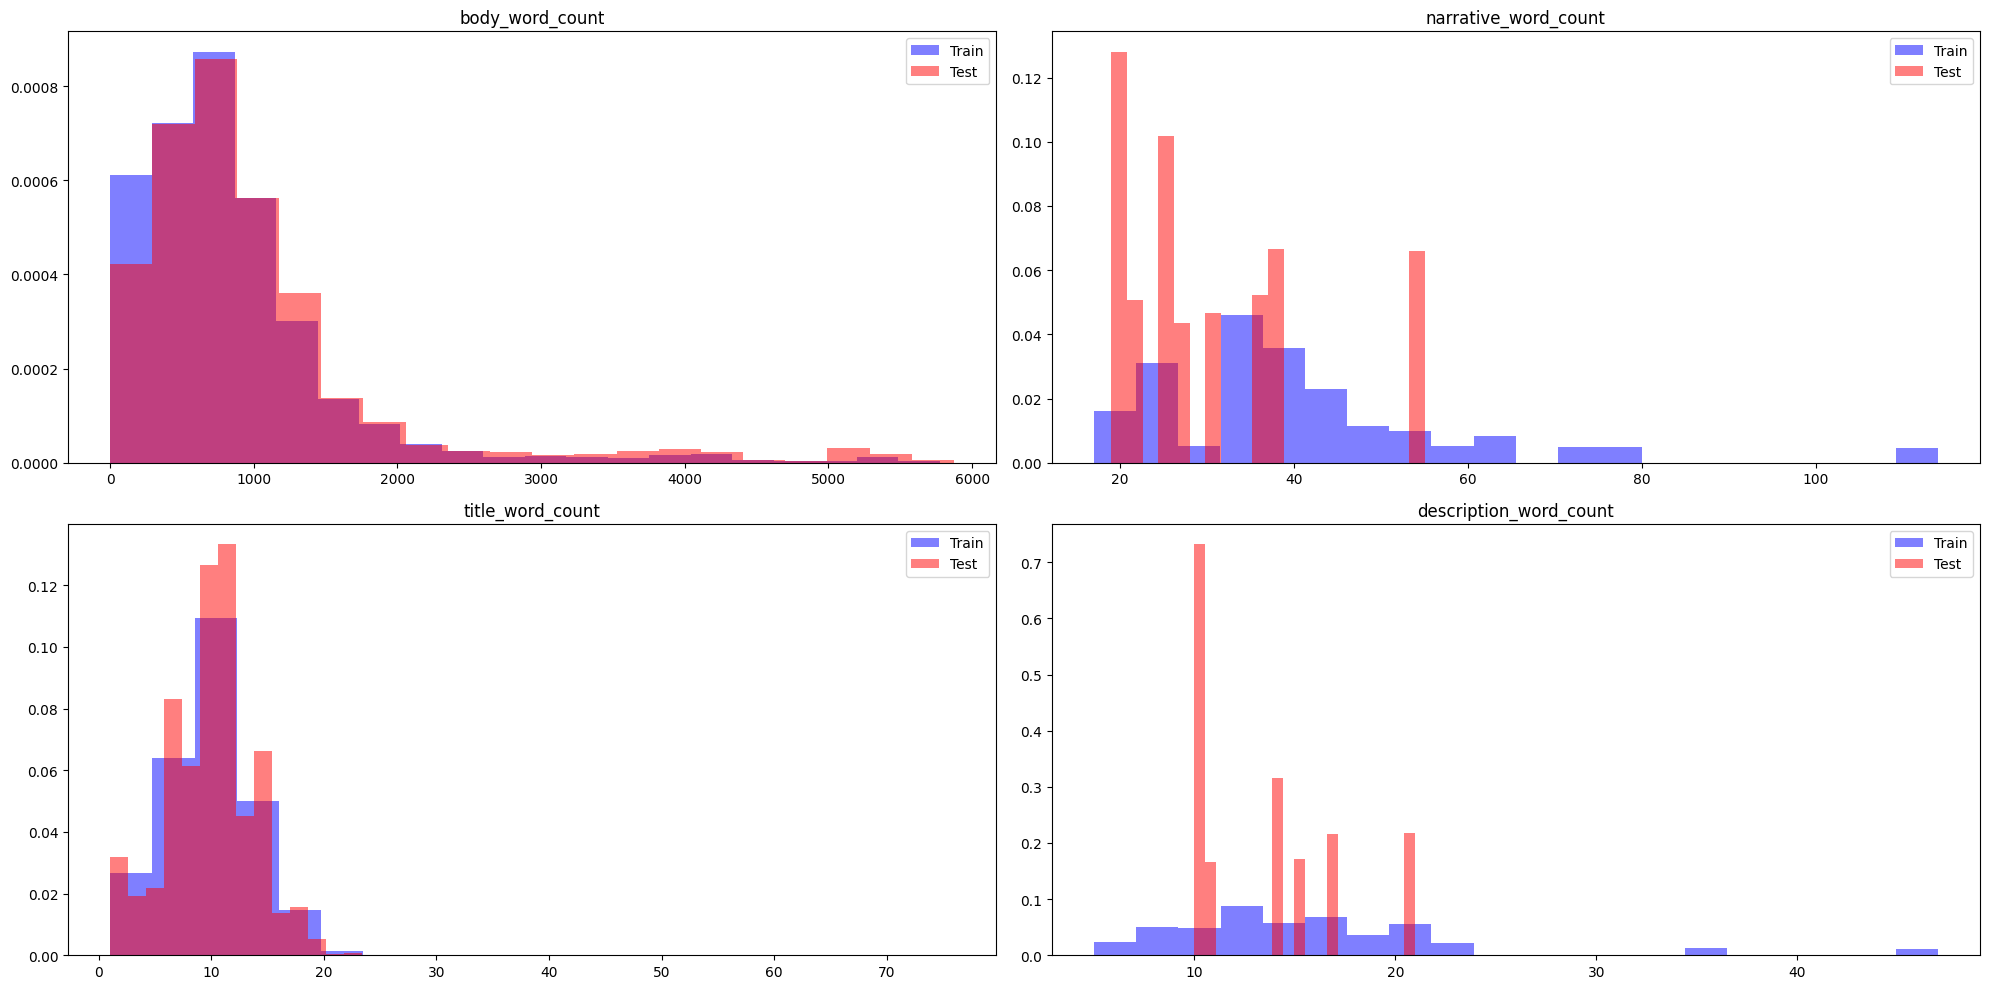

In [ ]:
# Extract columns with feature lengths
length_columns = ['body_word_count', 'narrative_word_count', 'title_word_count', 'description_word_count']

# Define the number of columns
n_columns = len(length_columns)


# Adjust the number of rows based on the number of columns
n_rows = n_cols // 2 if n_cols % 2 == 0 else (n_cols // 2) + 1
fig, axes = plt.subplots(n_rows, 2, figsize=(20, n_rows * 5))

# Plot each column in a separate subplot
for i, col in enumerate(length_columns):
    row = i // 2
    col_index = i % 2
    ax = axes[row, col_index]
    ax.hist(train_df[col], bins=20, alpha=0.5, label='Train', color='blue', density=True)
    ax.hist(test_df[col], bins=20, alpha=0.5, label='Test', color='red', density=True)
    ax.set_title(col)
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

### 2.1.3 - Word frequency analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('<a', 103499), ('—', 60115), ('said', 58359), ('would', 39878), ('one', 36379), ('people', 32959), ('new', 32559), ('also', 29547), ('could', 24585), ('two', 20468)]


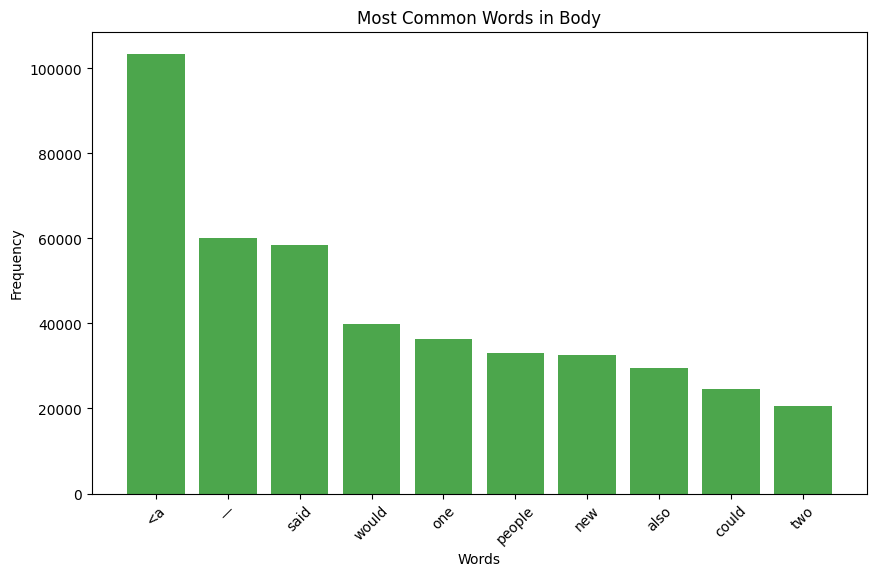

In [ ]:
# Import dictionary counter, nltk library and stopwords
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Download and extract stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Convert text into list of words
vocab = [word for text in train_df['body'].dropna() for word in str(text).lower().split() if word not in stop_words]

count_w = Counter(vocab)

# Most common words
most_common_words = count_w.most_common(10)
print(most_common_words)

# Bar plot of most frequent words in text
vocab, frequencies = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(vocab, frequencies, color='green', alpha=0.7)
plt.title('Most common words in body of text')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('relevant', 18496), ('documents', 16738), ('relevant.', 15552), ('document', 8006), ('discuss', 5490), ('describe', 4476), ('include', 3674), ('specific', 3310), ('identify', 3121), ('must', 3040)]


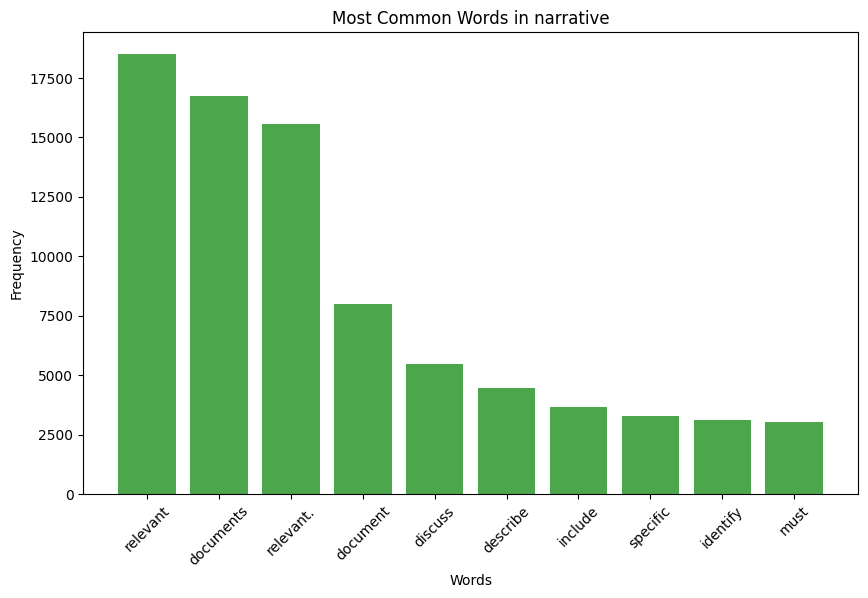

In [ ]:
# Convert narrative into list of words
vocab = [word for text in train_df['narrative'].dropna() for word in str(text).lower().split() if word not in stop_words]

count_w = Counter(vocab)

# Most common words
most_common_words = count_w.most_common(10)
print(most_common_words)

# Bar plot of most frequent words in narrative
vocab, frequencies = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(vocab, frequencies, color='green', alpha=0.7)
plt.title('Most common words in narrative')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('find', 8520), ('documents', 7957), ('discuss', 3532), ('identify', 3166), ('u.s.', 3075), ('describe', 2756), ('reports', 1577), ('women', 1550), ('would', 1448), ('efforts', 1429)]


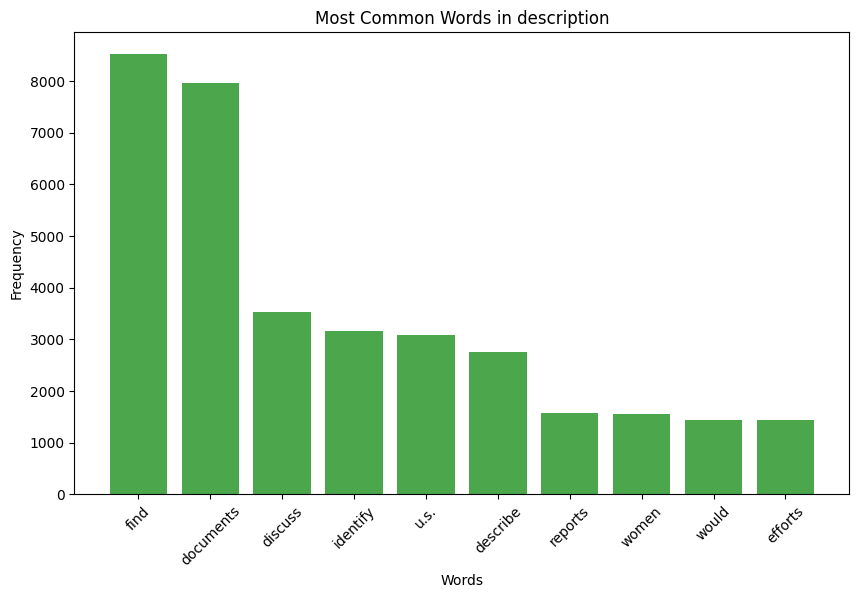

In [ ]:
# Convert description into list of words
vocab = [word for text in train_df['description'].dropna() for word in str(text).lower().split() if word not in stop_words]

count_w = Counter(vocab)

# Most common words
most_common_words = count_w.most_common(10)
print(most_common_words)

# Bar plot of most frequent words in description
vocab, frequencies = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(vocab, frequencies, color='green', alpha=0.7)
plt.title('Most common words in description')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('new', 904), ('u.s.', 641), ('trump', 495), ('—', 488), ('says', 457), ('could', 419), ('may', 400), ('world', 374), ('police', 351), ('metro', 350)]


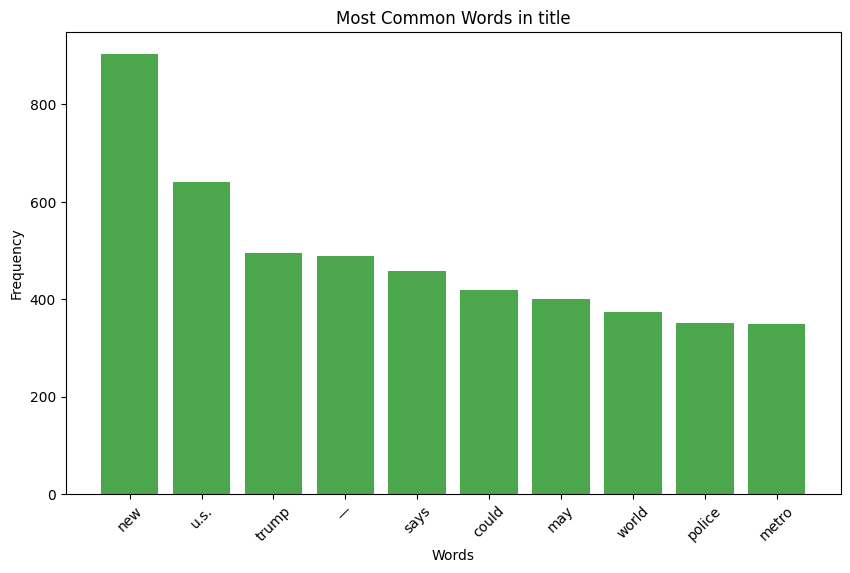

In [ ]:
# Convert title into list of words
vocab = [word for text in train_df['title'].dropna() for word in str(text).lower().split() if word not in stop_words]

count_w = Counter(vocab)

# Most common words
most_common_words = count_w.most_common(10)
print(most_common_words)

# Bar plot of most frequent words in title
vocab, frequencies = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(vocab, frequencies, color='green', alpha=0.7)
plt.title('Most common words in title')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

### 2.1.4 - Word clouds

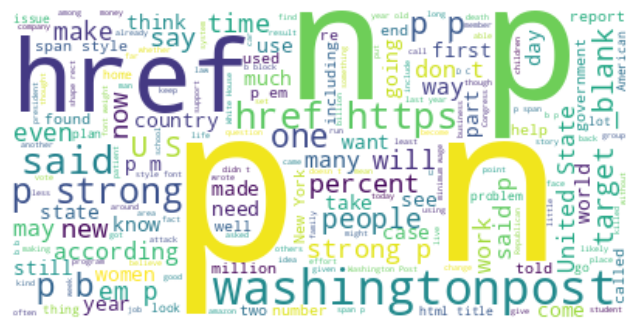

In [ ]:
# Import library to create word cloud
from wordcloud import WordCloud


# Convert data to a single string and remove none values
text = " ".join(check for check in train_df.body if check is not None)

# Create word cloud
word_cloud = WordCloud(background_color="white").generate(text)

# Show word cloud generated image
plt.figure(figsize=(8, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.1.5 - N - gram analysis

In [ ]:
# Import n-grams library
from nltk import ngrams


# Define function for building N-grams
def generate_ngrams(text, n=2):
    # Split text
    words = text.split()

    N_grams = ngrams(words, n)
    return [' '.join(grams) for grams in N_grams]

# Column selection for N-gram
whole_text = ' '.join(text for text in train_df.body if text is not None)

# Create bi-grams
bi_grams = generate_ngrams(whole_text, n=2)

# Dict count N-grams and print
bi_gram_counts = Counter(bi_grams)
print(bi_gram_counts.most_common(10))


[('of the', 102939), ('in the', 81600), ('to the', 44610), ('on the', 32563), ('for the', 26803), ('and the', 25357), ('that the', 23812), ('at the', 23806), ('to be', 23515), ('in a', 22860)]


### 2.1.6 - Waffle chart for class balance check

In [ ]:
# @title
# Install waffle chart
pip install pywaffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 56.8 MB/s eta 0:00:00


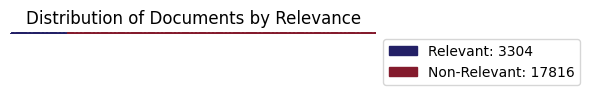

In [ ]:
# Import waffle chart library
from pywaffle import Waffle

# Define releveant and non-relevant documents
train_data = {
    'Relevant': len(train_df[train_df['judgement'] == 1]),
    'Non-Relevant': len(train_df[train_df['judgement'] == 0])
}


# Define and plot figure of relevant and non-relevant documents
figure = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=train_data,
    colors=["#232066", "#841B2D"],
    title={'label': 'Distribution of documents by relevance', 'loc': 'center'},
    labels=[f"{k}: {v}" for k, v in train_data.items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    figsize=(6, 4)
)

plt.show()


# 3. Data preprocessing and data splitting

## 3.1 - Baseline model

In [ ]:
# Drop document ID column from training and test set
train_df = train_df.drop(columns = ['doc_id'], axis = 1)
test_df = test_df.drop(columns = ['doc_id'], axis = 1)

### 3.1.1 - Removing upper case

In [ ]:
# Creating new column to hold cleaned text
train_df['clean_text'] = train_df['body'].str.lower()
test_df['clean_text'] = test_df['body'].str.lower()

### 3.1.2 - Removing special characters

In [ ]:
# Defining function to remove special characters from text
def remove_special_characters(dataframe):
  # Replaces special characters with whitespace
  n_special_characters = dataframe.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
  return n_special_characters


In [ ]:
# Remove special chracters from training and testing set using function
train_cleaned_df = remove_special_characters(train_df)
test_cleaned_df = remove_special_characters(test_df)

### 3.1.3 - Removing stopwords

In [ ]:
# Import necessary libraries
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords


# Download and extract stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords
def remove_stopwords(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return text
    # Tokenise the words in the text data
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
    return ' '.join(filtered_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Apply stop word function to training and testing sets
train_cleaned_df['clean_text'] = train_cleaned_df['clean_text'].apply(remove_stopwords)
test_cleaned_df['clean_text'] = test_cleaned_df['clean_text'].apply(remove_stopwords)

### 3.1.4 - Removing whitespace

In [ ]:
# Defining function to remove whitespace
def remove_whitespace(dataframe, columns):
    for column in columns:
        # removing extra whitespace between text
        dataframe[column] = dataframe[column].str.replace(r"\s\s+", ' ', regex=True)

        # Removing whitespace at start and end of text
        dataframe[column] = dataframe[column].str.strip()
    return dataframe

In [ ]:
# Apply whitespace removal function to training and testing sets
final_train_df = remove_whitespace(train_cleaned_df, ['author', 'body', 'byline', 'title', 'description', 'narrative', 'topic_title', 'clean_text'])
final_test_df = remove_whitespace(test_cleaned_df, ['author', 'body', 'byline', 'title', 'description', 'narrative', 'topic_title', 'clean_text'])

### 3.1.5 - Removing unexpected p and html links

In [ ]:
# Import necessary libraries
import re

# Define function to remove letter p present in text
def p_removal(data):
  return re.sub(r'\bp(?!p)', '', data)

# Define a function for removing html links in text data
def html_removal(data):
  return re.sub(r'https?://\S+|www\.\S+', '', data)

# Define function to apply both p and html removal from text simultaneously
def p_html_removal(data):
  html_free_text = html_removal(data)
  clean_text = p_removal(html_free_text)
  return clean_text

In [ ]:
# Ensure all text is in a string format
final_train_df['clean_text'] = final_train_df['clean_text'].astype(str)
final_test_df['clean_text'] = final_test_df['clean_text'].astype(str)


# Ensure any none values are just replaced with whitespace
final_train_df = final_train_df.fillna('')
final_test_df = final_test_df.fillna('')

# Apply letter p and html link removal function to training and testing sets
final_train_df['clean_text'] = final_train_df['clean_text'].apply(p_html_removal)
final_test_df['clean_text'] = final_test_df['clean_text'].apply(p_html_removal)

### 3.1.6 - Baseline data splitting

In [ ]:
# Import train and test splitting library
from sklearn.model_selection import train_test_split

# Create a training and testing sets of main clean text and relevance columns
X_train, X_test, y_train_ML, y_test_ML = train_test_split(
    final_train_df['clean_text'], final_train_df['judgement'],
    test_size=0.2, random_state=42
    )


### 3.1.7 - TF-IDF vectorisation

In [ ]:
# Import TF-IDF vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer


# Define vectoriser
vectoriser = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2))

# Replace any none values with whitespace
X_train_clean = X_train.fillna('')
X_test_clean = X_test.fillna('')

# Apply TF-IDF vectorisation to both training and testing set
X_train_tfidf = vectoriser.fit_transform(X_train_clean)
X_test_tfidf = vectoriser.transform(X_test_clean)

## 3.2 - 3 layer neural network baseline and deep neural network

###3.2.1 - Removing html tags

In [8]:
training_columns=train_df_NN_base.columns

# Function to check for HTML tags in a column
def check_html_tags(column):
    # Conventional expression for detecting HTML tags
    html_tag_re = re.compile(r'<[^>]+>')
    # Applying regex to the a selected column, checking if any row contains HTML tags
    return column.apply(lambda x: bool(html_tag_re.search(x)) if isinstance(x, str) else False)

# Checking each column of the training dataframe
columns_with_html = {column: check_html_tags(train_df_NN_base[column]).any() for column in training_columns}

print(columns_with_html)

{'doc_id': False, 'judgement': False, 'author': False, 'body': True, 'byline': False, 'title': True, 'topic_id': False, 'description': False, 'narrative': False, 'topic_title': False}


In [9]:
## Therefore The title and body column contains HTMTL tags which I will go on to remove

columns_with_HTML_tags=["body","title"]

def clean_html_tags(data):
  # Checking if the input data is a string; if not, return the data as is.
  if not isinstance(data, str):
        return data
  # deploy regular expressions to remove any HTML tags from the string and return the cleaned string.
  return re.sub(r'<[^>]+>', '', data)

# Iterate over each column in the list `columns_with_HTML_tags` of the train DataFrame
for column in columns_with_HTML_tags:
  train_df_NN_base[column]=train_df_NN_base[column].apply(clean_html_tags)  # Apply the `clean_html_tags` function to each element of the column to remove HTML tags.

In [10]:
#repeating similar HTML tag removal steps for designated columns in the test dataset
for column in columns_with_HTML_tags:
  test_df_NN_base[column]=test_df_NN_base[column].apply(clean_html_tags)

### 3.2.2 - Convert text to lower case

In [11]:
# Convert all text in the 'body' column of the train and test DataFrame to lowercase.
train_df_NN_base['body'] = train_df_NN_base['body'].str.lower()
test_df_NN_base['body'] = test_df_NN_base['body'].str.lower()

### 3.2.3 - Removing URL links

In [13]:
test_columns=test_df_NN_base.columns

In [14]:
def html_removal(column):

  # Check if the input column data is a string; if not, return the data unchanged.
  if not isinstance(column, str):
        return column
  # Use regular expressions to remove URLs from the string and return the modified string.
  return re.sub(r'https?://\S+|www\.\S+', '', column)

# Iterate over each column specified in the list `training_columns` for the training DataFrame.
for column in training_columns:
  # Apply the `html_removal` function to each element of the column to remove URLs.
  train_df_NN_base[column]=train_df_NN_base[column].apply(html_removal)

#Repeat similar procedure for the test dataframe
for column in test_columns:
  test_df_NN_base[column]=test_df_NN_base[column].apply(html_removal)

### 3.2.4 - Replacing number with placeholders

In [15]:
def replace_numbers(column):
    # Check if the input column data is a string; if not, return the data unchanged.
    if not isinstance(column, str):
        return column
    # Use regular expressions to replace all sequences of digits in the string with '#s'.
    return re.sub(r'\d+', '#s', column)

# List of column names in the DataFrame where the text transformation will be applied.
relevant_columns=['body', 'byline', 'title','description', 'narrative', 'topic_title']

# Iterate over each column name stored in 'relevant_columns'.
for column in relevant_columns:

  train_df_NN_base[column]=train_df_NN_base[column].apply(replace_numbers)
  test_df_NN_base[column]=test_df_NN_base[column].apply(replace_numbers)

### 3.2.5 - Removing other special characters

In [16]:
def clean_text(text):

  # Check if the input data is of type string; if not, return it unchanged.
  if not isinstance(text,str):
    return text
  # Use a regular expression to remove special characters and control characters from the text.
  cleaned_text = re.sub(r'[\n\\n\r\\r\t\\t\v\\v\f\\f\xa0]+|[^a-zA-Z0-9.,#!?\'` ]', ' ', text)
  # Replace multiple spaces with a single space.
  cleaned_text = re.sub(r' +', ' ', cleaned_text)
  return cleaned_text.strip() # Strip leading and trailing spaces and return the cleaned text.

relevant_columns=['body', 'byline', 'title','description', 'narrative', 'topic_title'] # List of column names in the DataFrame to apply the text cleaning.

# Loop over each column specified in the list of relevant columns.
for column in relevant_columns:

  train_df_NN_base[column]=train_df_NN_base[column].apply(clean_text)
  test_df_NN_base[column]=test_df_NN_base[column].apply(clean_text)

### 3.2.6 - Removing stop words

In [19]:
def clean_stopwords(column):

     # Check if the input data is a string; if not, return it unchanged.
    if not isinstance(column, str):
        return column

    stop_words = set(stopwords.words('english')) # Load a set of English stopwords.

    word_tokens = word_tokenize(column) # Tokenize the input column into words.

    filtered_text = [item for item in word_tokens if item.lower() not in stop_words] # Filter out any words that are in the list of stopwords.

    # Combining the filtered words back into a string
    return ' '.join(filtered_text)

# Fetching list of column names in the DataFrame to apply the stopwords removal.
relevant_columns=['body', 'byline', 'title','description', 'narrative', 'topic_title']

for column in relevant_columns: # Loop over each column specified in the list of relevant columns.

  # Apply the 'clean_stopwords' function to each element in the specified column of the training and test DataFrame.
  train_df_NN_base[column]=train_df_NN_base[column].apply(clean_stopwords)
  test_df_NN_base[column]=test_df_NN_base[column].apply(clean_stopwords)

### 3.2.7 - Implementing lemmatisation with SpaCy

In [20]:
#Note that SpaCy was particularly preferred ahead of NLTK based on the former's capacity to integrate contextual meaning from part of speech

# Loading the SpaCy model
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize(column):
    # Immplementing lemmatization of text with SpaCy
    if not isinstance(column, str):
        return column
    document = nlp(column)

    # Extract the lemma for each token and join back into a string
    return ' '.join([token.lemma_ for token in document])

relevant_columns=['body','title','description', 'narrative', 'topic_title']

#Iterating over designated columns in training and test datasets to apply lemmatisation

for column in relevant_columns:

  train_df_NN_base[column]=train_df_NN_base[column].apply(spacy_lemmatize)
  test_df_NN_base[column]=test_df_NN_base[column].apply(spacy_lemmatize)

## 3.3 - Complex model (BSSN)

In [32]:
# Create a copy of test document IDs for submission
test_doc_ids = test_df_NN['doc_id'].copy()

### 3.3.1 - Remove special characters and stopword function definition for multiple features

In [ ]:
# Define functions fro removing special chracters and stopwords for multiple columns
def remove_special_characters_2(text):
    # Using re.sub to replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return cleaned_text

def remove_stopwords_2(text):
  # Tokenise words
    tokens = text.split()
    # Filter through tokens and eliminate stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

### 3.3.2 - Applied removal of stopwords, special characters and html links


In [ ]:
# Import necessary libraries
# Download and extract stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Create function to apply all preprocessing functions simultaneously defined previously
def preprocess_text(data, column):
    # Convert text to s atring
    data[column] = data[column].astype(str)
    # Apply function to remove html links
    data[column] = data[column].apply(lambda x: re.sub(r'<[^>]*>', '', x))
    # Apply function to remove special characters
    data[column] = data[column].apply(remove_special_characters_2)
    # Apply function to remove stop words
    data[column] = data[column].apply(remove_stopwords_2)
    return data


# Create new column to hold all text data with whitespace used for seperation
train_df_NN['combined_text'] = train_df_NN['title'].fillna('') + " " + train_df_NN['description'].fillna('') + " " + train_df_NN['narrative'].fillna('') + " " + train_df_NN['topic_title'].fillna('')
test_df_NN['combined_text'] = test_df_NN['title'].fillna('') + " " + test_df_NN['description'].fillna('') + " " + test_df_NN['narrative'].fillna('') + " " + test_df_NN['topic_title'].fillna('')


# Apply preprocessing function to both training and testing set
train_df_NN_cleaned = preprocess_text(train_df_NN, 'body')
train_df_NN_cleaned = preprocess_text(train_df_NN, 'combined_text')

test_df_NN_cleaned = preprocess_text(test_df_NN, 'body')
test_df_NN_cleaned = preprocess_text(test_df_NN, 'combined_text')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Drop document ID column
train_df_NN_cleaned = train_df_NN_cleaned.drop(columns = ['doc_id'], axis = 1)
test_df_NN_cleaned = test_df_NN_cleaned.drop(columns = ['doc_id'], axis = 1)

### 3.3.3 - BSSN data splitting

In [ ]:
# Create training data by extracting text features and target feature
X_train_full = train_df_NN_cleaned[['body', 'combined_text']]
y_train_full = train_df_NN_cleaned['judgement']

# Further split training data into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

### 3.3.4 - Tokenisation of data

In [ ]:
# Define tokeniser
tokeniser = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create function to tokenise datasets
def tokenise_BSSN(text):
    # Tokenise multiple input data
    body_encodings = tokeniser(text['body'], truncation=True, padding='max_length', max_length=512, return_tensors='tf')
    combined_text_encodings = tokeniser(text['combined_text'], truncation=True, padding='max_length', max_length=512, return_tensors='tf')
    return {
        'input_ids_body': body_encodings['input_ids'],
        'attention_mask_body': body_encodings['attention_mask'],
        'input_ids_combined': combined_text_encodings['input_ids'],
        'attention_mask_combined': combined_text_encodings['attention_mask']
    }

# Apply tokenisation function to training, validation and testing set
train_encodings = tokenise_BSSN({'body': X_train['body'].tolist(), 'combined_text': X_train['combined_text'].tolist()})
val_encodings = tokenise_BSSN({'body': X_val['body'].tolist(), 'combined_text': X_val['combined_text'].tolist()})
test_encodings = tokenise_BSSN({'body': test_df_NN_cleaned['body'].tolist(), 'combined_text': test_df_NN_cleaned['combined_text'].tolist()})

# Convert labels to tensors to ensure consistency
train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
val_labels = tf.convert_to_tensor(y_val, dtype=tf.int32)

# Create tensorflow datasets from tokenised data
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels)).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_encodings, val_labels)).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_encodings).batch(16).prefetch(tf.data.AUTOTUNE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 4. Models

## 4.1 -  Standard ML baseline models

For the baseline models logistic regression, decision tree and SVM were used to provide a performance comparison with the non-linear models. The SVM model deployed a linear kernel, where hyperparameter tuning found C = 1 to be optimal. Decision trees were hyperparameter tuned with a max depth of 2, min samples per leaf of 1 and min samples split of 2.

### 4.1.1 - Logistic regression model building

In [ ]:
# Import necessary libraries for scoring and modelling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score

# Define scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Initialize and train the logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_tfidf, y_train_ML)

# Apply cross-validation to training data
scores_log = cross_validate(model, X_train_tfidf, y_train_ML, cv=5, scoring = scoring)

# Print metric scores
print("Accuracy scores for each fold:", scores_log['test_accuracy'])
print(f"Mean cross-validation accuracy: {scores_log['test_accuracy'].mean():.2f}")
print("Precision scores for each fold:", scores_log['test_precision'])
print(f"Mean cross-validation precision: {scores_log['test_precision'].mean():.2f}")
print("Recall scores for each fold:", scores_log['test_recall'])
print(f"Mean cross-validation recall: {scores_log['test_recall'].mean():.2f}")

Accuracy scores for each fold: [0.82669197 0.83612781 0.83106612 0.83201519 0.81872825]
Mean cross-validation accuracy: 0.83
Precision scores for each fold: [0.46561605 0.48710991 0.47592847 0.47795164 0.45178336]
Mean cross-validation precision: 0.47
Recall scores for each fold: [0.65       0.71943888 0.69338677 0.672      0.684     ]
Mean cross-validation recall: 0.68


### 4.1.2 - Support vector machine (SVM) model building

In [ ]:
# Import SVM model
from sklearn.svm import LinearSVC

# Define SVM model
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train_ML)

# Apply cross-validation to training data
scores_svm = cross_validate(svm_model, X_train_tfidf, y_train_ML, cv=5, scoring = scoring)

# Print metric scores
print("Accuracy scores for each fold:", scores_svm['test_accuracy'])
print(f"Mean cross-validation accuracy: {scores_svm['test_accuracy'].mean():.2f}")
print("Precision scores for each fold:", scores_svm['test_precision'])
print(f"Mean cross-validation precision: {scores_svm['test_precision'].mean():.2f}")
print("Recall scores for each fold:", scores_svm['test_recall'])
print(f"Mean cross-validation recall: {scores_svm['test_recall'].mean():.2f}")

Accuracy scores for each fold: [0.83934219 0.84625119 0.84498576 0.83992407 0.83644416]
Mean cross-validation accuracy: 0.84
Precision scores for each fold: [0.49319728 0.50992366 0.50761421 0.49491525 0.4870229 ]
Mean cross-validation precision: 0.50
Recall scores for each fold: [0.58       0.66933868 0.6012024  0.584      0.638     ]
Mean cross-validation recall: 0.61


### 4.1.3 - Hyperparameter tune SVM model

In [ ]:
# Import grid search
from sklearn.model_selection import GridSearchCV

# Define parameters for grid search optimisation
parameter_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Initialize GridSearchCV
grid_search_model = GridSearchCV(svm_model, parameter_grid, cv=5, n_jobs=-1)

# Fit the Grid search model to training data
grid_search_model.fit(X_train_tfidf, y_train_ML)

# Print best scores from cross-validation
print("Best cross-validation score: {:.2f}".format(grid_search_model.best_score_))
print("Best parameters:", grid_search_model.best_params_)

# Generate test score form best found model
test_score = grid_search_model.score(X_test_tfidf, y_test_ML)
print("Test score with best parameters: {:.2f}".format(test_score))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best cross-validation score: 0.84
Best parameters: {'C': 1}
Test score with best parameters: 0.86


### 4.1.4 - Decision tree classifier model building



In [ ]:
# Import decsion tree classifier model
from sklearn.tree import DecisionTreeClassifier

# Define decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth = 2, class_weight='balanced')

# Apply cross-validation to training data
scores_tree_clf = cross_validate(tree_clf, X_train_tfidf, y_train_ML, cv=5, scoring = scoring)

# Print metric scores
print("Accuracy scores for each fold:", scores_tree_clf['test_accuracy'])
print(f"Mean cross-validation accuracy: {scores_tree_clf['test_accuracy'].mean():.2f}")
print("Precision scores for each fold:", scores_tree_clf['test_precision'])
print(f"Mean cross-validation precision: {scores_tree_clf['test_precision'].mean():.2f}")
print("Recall scores for each fold:", scores_tree_clf['test_recall'])
print(f"Mean cross-validation recall: {scores_tree_clf['test_recall'].mean():.2f}")

Accuracy scores for each fold: [0.81593928 0.80544132 0.81999367 0.82252452 0.80227776]
Mean cross-validation accuracy: 0.81
Precision scores for each fold: [0.34108527 0.32941176 0.35416667 0.37651822 0.32590529]
Mean cross-validation precision: 0.35
Recall scores for each fold: [0.176      0.2244489  0.17034068 0.186      0.234     ]
Mean cross-validation recall: 0.20


### 4.1.5 - Hyperparameter tuning decison tree classifier

In [ ]:
# Define parameters for grid search optimisation
param_grid = {
    'max_depth': [None, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize GridSearchCV
grid_search_tree_clf = GridSearchCV(tree_clf, param_grid, cv=5, n_jobs=-1)

# Fit the Grid search model to training data
grid_search_tree_clf.fit(X_train_tfidf, y_train_ML)

# Print best scores from cross-validation
print("Best cross-validation score: {:.2f}".format(grid_search_tree_clf.best_score_))
print("Best parameters:", grid_search_tree_clf.best_params_)

# Generate test score form best found model
test_score_tree = grid_search_tree_clf.score(X_test_tfidf, y_test_ML)
print("Test score with best parameters: {:.2f}".format(test_score_tree))

Best cross-validation score: 0.81
Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test score with best parameters: 0.82


## 4.2 - 3 layer neural network baseline model building

Our approach leveraged a functional implementation. After tokenization and vectorization, I implemented an embedding matrix based on the GloVe vectors. The model receives multiple tokenized input texts (author, byline, narrative, topic title, body, description, and title), with a shared embedding.
From there, I concatenated embeddings, flattened them and fed into the dense layer. The dense layer was further enhanced with batch normalization and L2 regularization to prevent overfitting.
After this, I compiled the model binary crossentropy loss function (given I have a binary classification) and the 'adam' optimizer.

### 4.2.1 - Tokenisation and vectorisation

In [7]:
X_train_NN_base=train_df_NN_base.drop("judgement",axis=1) #Extracting the training features

In [8]:
y_train_NN_base=train_df_NN_base["judgement"] #Fetching the train labels
X_test_NN_base=test_df_NN_base

In [9]:
#Remove illevant columns from X_test and X_train

X_train_NN_base.drop("doc_id",axis=1,inplace=True)
X_test_NN_base.drop("doc_id",axis=1,inplace=True)

# Replace None with 'unknown' across the entire DataFrame
X_train_NN_base.fillna('unknown', inplace=True)
X_test_NN_base.fillna('unknown', inplace=True)

In [10]:
# Split the data into training and validation sets with stratification
X_train_NN_base, X_val_NN_base, y_train_NN_base, y_val_NN_base = train_test_split(X_train_NN_base, y_train_NN_base, test_size=0.2, stratify=y_train_NN_base, random_state=42)

In [11]:
def tokenize_column(column, max_length):

    tokenizer = Tokenizer() # Initialize a Tokenizer object from Keras' text processing utilities.

    tokenizer.fit_on_texts(column) # Fit the tokenizer on the text data; this step builds the word index.

    # Convert the text data to sequences of integers where each integer
    # represents a specific word in a dictionary created by the tokenizer.
    sequences = tokenizer.texts_to_sequences(column)

    # Pad the sequences so all sequences in the list have the same length.
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    return padded_sequences, tokenizer

In [12]:
# Calculating a suitable max_length for padding

# Start by initializing a list to collect the lengths of all tokenized entries across different text columns.
lengths = []

# Iterate over each text column in the training data.
for text_column in [X_train_NN_base['author'], X_train_NN_base['body'], X_train_NN_base['byline'], X_train_NN_base['title'], X_train_NN_base['description'], X_train_NN_base['narrative'], X_train_NN_base['topic_title']]:

    tokenizer = Tokenizer() # Create a Tokenizer instance for each column

    tokenizer.fit_on_texts(text_column) # Fit the tokenizer on the text column to build the vocabulary

    seq = tokenizer.texts_to_sequences(text_column) # Convert the texts to sequences of integers

    lengths.extend([len(x) for x in seq]) # Extend the 'lengths' list with the length of each sequence in the column

max_length_used = max(lengths)  # This is a fairly robust strategy, ensuring no information loss
print(max_length_used)

5412


### 4.2.1 (A) - Vectorizing all columns in the training,validation, and test dataframe

In [13]:
# Vectorize 'body' column

# Convert the 'body' column of the training data to a list of text entries.
train_body = X_train_NN_base['body'].tolist()

# Tokenize and pad the 'body' texts from the training data. Also, retrieve the tokenizer.
train_body_padded, body_tokenizer = tokenize_column(train_body,max_length_used)
# Determine the maximum length of sequences in the training data, used for consistent padding.
max_length_used = train_body_padded.shape[1]

# Convert the 'body' column of the validation data to a list of text entries.
val_body = X_val_NN_base['body'].tolist()

# Tokenize the 'body' texts from the validation data using the existing tokenizer.
val_body_padded= body_tokenizer.texts_to_sequences(val_body)

# Pad the tokenized sequences from the validation data to the maximum length determined from training data.
val_body_padded = pad_sequences(val_body_padded, maxlen=max_length_used, padding='post')

# Convert the 'body' column of the testing data to a list of text entries.
test_body = X_test_NN_base['body'].tolist()

# Tokenize the 'body' texts from the testing data using the existing tokenizer.
test_body_padded= body_tokenizer.texts_to_sequences(test_body)

# Pad the tokenized sequences from the testing data to the maximum length determined from training data.
test_body_padded = pad_sequences(test_body_padded, maxlen=max_length_used, padding='post')

print(max_length_used)

#Given that the body has the largest content among all features, we would use its length for uniform padding of other columns


5412


In [14]:
# Vectorize 'author' column
# Convert the 'author' column of the training data to a list of text entries.
train_author = X_train_NN_base['author'].tolist()
# Tokenize and pad the 'author' texts from the training data. Retrieve the tokenizer used.
train_author_padded, author_tokenizer = tokenize_column(train_author,max_length_used)
# Convert the 'author' column of the validation data to a list of text entries.
val_author = X_val_NN_base['author'].tolist()
# Tokenize the 'author' texts from the validation data using the existing tokenizer.
val_author_padded= author_tokenizer.texts_to_sequences(val_author)
# Pad the tokenized sequences from the validation data to the maximum length determined from training data.
val_author_padded = pad_sequences(val_author_padded, maxlen=max_length_used, padding='post')
# Convert the 'author' column of the testing data to a list of text entries.
test_author = X_test_NN_base['author'].tolist()
# Tokenize the 'author' texts from the testing data using the existing tokenizer.
test_author_padded= author_tokenizer.texts_to_sequences(test_author)
# Pad the tokenized sequences from the testing data to the maximum length determined from training data.
test_author_padded = pad_sequences(test_author_padded, maxlen=max_length_used, padding='post')
print(max_length_used)

5412


### 4.2.1 (B) - Similar vectorization process will be applied to the "byline","title","description","narrative", and "topic_title" columns in the following cells

In [15]:
# Vectorize 'byline' column
train_byline = X_train_NN_base['byline'].tolist()
train_byline_padded, byline_tokenizer = tokenize_column(train_byline,max_length_used)

val_byline = X_val_NN_base['byline'].tolist()
val_byline_padded= byline_tokenizer.texts_to_sequences(val_byline)
val_byline_padded = pad_sequences(val_byline_padded, maxlen=max_length_used, padding='post')

test_byline = X_test_NN_base['byline'].tolist()
test_byline_padded= byline_tokenizer.texts_to_sequences(test_byline)
test_byline_padded = pad_sequences(test_byline_padded, maxlen=max_length_used, padding='post')

In [16]:
# Vectorize 'title' column
train_title = X_train_NN_base['title'].tolist()
train_title_padded, title_tokenizer = tokenize_column(train_title,max_length_used)

val_title = X_val_NN_base['title'].tolist()
val_title_padded= title_tokenizer.texts_to_sequences(val_title)
val_title_padded = pad_sequences(val_title_padded, maxlen=max_length_used, padding='post')

test_title = X_test_NN_base['title'].tolist()
test_title_padded= title_tokenizer.texts_to_sequences(test_title)
test_title_padded = pad_sequences(test_title_padded, maxlen=max_length_used, padding='post')

In [17]:
# Vectorize 'description' column
train_description = X_train_NN_base['description'].tolist()
train_description_padded, description_tokenizer = tokenize_column(train_description,max_length_used)

val_description = X_val_NN_base['description'].tolist()
val_description_padded= description_tokenizer.texts_to_sequences(val_description)
val_description_padded = pad_sequences(val_description_padded, maxlen=max_length_used, padding='post')

test_description = X_test_NN_base['description'].tolist()
test_description_padded= description_tokenizer.texts_to_sequences(test_description)
test_description_padded = pad_sequences(test_description_padded, maxlen=max_length_used, padding='post')

In [18]:
# Vectorize 'narrative' column
train_narrative = X_train_NN_base['narrative'].tolist()
train_narrative_padded, narrative_tokenizer = tokenize_column(train_narrative,max_length_used)

val_narrative = X_val_NN_base['narrative'].tolist()
val_narrative_padded= narrative_tokenizer.texts_to_sequences(val_narrative)
val_narrative_padded = pad_sequences(val_narrative_padded, maxlen=max_length_used, padding='post')

test_narrative = X_test_NN_base['narrative'].tolist()
test_narrative_padded= narrative_tokenizer.texts_to_sequences(test_narrative)
test_narrative_padded = pad_sequences(test_narrative_padded, maxlen=max_length_used, padding='post')

In [19]:
# Vectorize 'topic_title' column
train_topic_title = X_train_NN_base['topic_title'].tolist()
train_topic_title_padded, topic_title_tokenizer = tokenize_column(train_topic_title,max_length_used)

val_topic_title = X_val_NN_base['topic_title'].tolist()
val_topic_title_padded= topic_title_tokenizer.texts_to_sequences(val_topic_title)
val_topic_title_padded = pad_sequences(val_topic_title_padded, maxlen=max_length_used, padding='post')

test_topic_title = X_test_NN_base['topic_title'].tolist()
test_topic_title_padded= topic_title_tokenizer.texts_to_sequences(test_topic_title)
test_topic_title_padded = pad_sequences(test_topic_title_padded, maxlen=max_length_used, padding='post')

### 4.2.2 - Executing GloVe Embedding

In [20]:
def set_seed(seed_value):
    np.random.seed(seed_value)  # Set seed for NumPy operations
    random.seed(seed_value)     # Set seed for Python random operations
    tf.random.set_seed(seed_value)  # Set seed for TensorFlow operations

In [21]:
import gdown

# URL for the GloVe embeddings file on Google Drive
glove_url = 'https://drive.google.com/uc?id=1Xb2-z9iyjWau7iirLDP-WG4330nskwDv'

# Use gdown to download the file directly
output_filename = 'glove.6B.100d.txt'
gdown.download(glove_url, output_filename, quiet=False)

# Now, load the GloVe embeddings from the downloaded file
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load the GloVe embeddings using the function defined above
glove_embeddings = load_glove_embeddings(output_filename)
print("Loaded embeddings for", len(glove_embeddings),"words.")

Downloading...
From (original): https://drive.google.com/uc?id=1Xb2-z9iyjWau7iirLDP-WG4330nskwDv
From (redirected): https://drive.google.com/uc?id=1Xb2-z9iyjWau7iirLDP-WG4330nskwDv&confirm=t&uuid=2e6f4433-5d4f-42c6-a6a4-7c28d30be9d4
To: /content/glove.6B.100d.txt
100%|██████████| 347M/347M [00:04<00:00, 77.5MB/s]


Loaded embeddings for 400000 words.


### 4.2.3 - Model building

In [44]:
K.clear_session() # Clear any previous model session to free memory and prevent interference.

embedding_dim = 100  # Dimensionality of the GloVe embedding vectors

vocab_size = len(body_tokenizer.word_index) + 1 # Size of the vocabulary in the dataset noting padding

max_length=max_length_used # Maximum length of sequences used for padding.

# Initialize an embedding matrix that will hold the pre-trained embeddings.
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe vectors
for word, i in body_tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # words not found in embedding index will be all-zeros

# Define input layers for each feature of the dataset
author_input = Input(shape=(max_length,), dtype='int32')
byline_input = Input(shape=(max_length,), dtype='int32')
narrative_input = Input(shape=(max_length,), dtype='int32')
topic_title_input = Input(shape=(max_length,), dtype='int32')
body_input = Input(shape=(max_length,), dtype='int32')
description_input = Input(shape=(max_length,), dtype='int32')
title_input = Input(shape=(max_length,), dtype='int32')

# Define a shared embedding layer using the GloVe embedding matrix.
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

# Create embeddings for each input by passing them through the shared embedding layer.
author_embeddings = embedding_layer(author_input)
byline_embeddings = embedding_layer(byline_input)
narrative_embeddings = embedding_layer(narrative_input)
topic_title_embeddings = embedding_layer(topic_title_input)
body_embeddings = embedding_layer(body_input)
description_embeddings = embedding_layer(description_input)
title_embeddings = embedding_layer(title_input)

# Concatenate all embeddings into a single tensor.
concatenated_embeddings = concatenate([author_embeddings, byline_embeddings, narrative_embeddings, topic_title_embeddings, body_embeddings, description_embeddings, title_embeddings])

# Flatten the concatenated embeddings to create a feature vector.
concatenated_embeddings = Flatten()(concatenated_embeddings)
# Add a dense layer with regularization and normalization.
hidden1=Dense(100,activation="relu",kernel_regularizer=l2(0.01))(concatenated_embeddings)
hidden1 = BatchNormalization()(hidden1) # Apply dropout to prevent overfitting.
hidden1 = Dropout(0.5)(hidden1)  # Adding dropout
output = Dense(1, activation='sigmoid')(hidden1)

# Construct the model with all inputs and the single output.
model = Model(inputs=[author_input, byline_input, narrative_input, topic_title_input, body_input, description_input, title_input], outputs=output)
# Compile the model with the Adam optimizer and binary crossentropy loss function.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary() # Display the model architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5412)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5412)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 5412)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 5412)]               0         []                            
                                                                                              

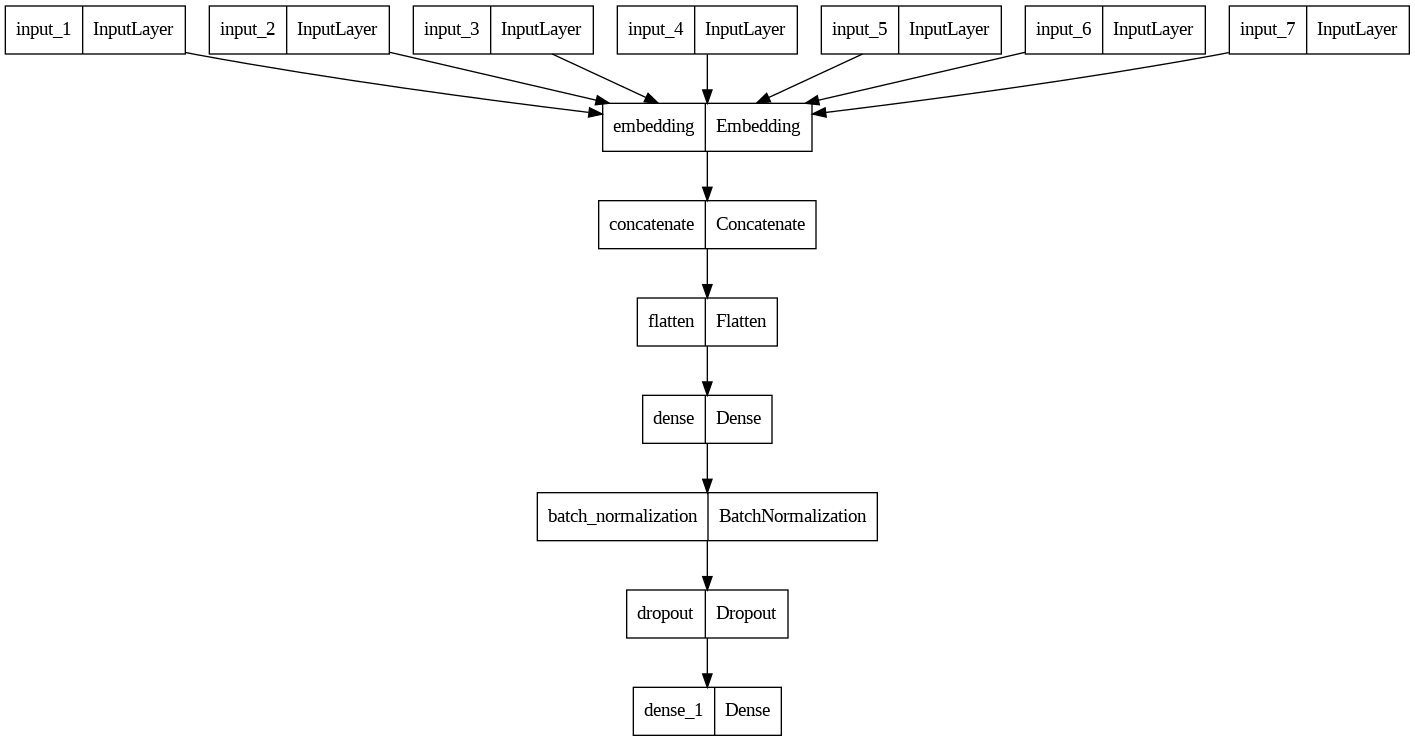

In [47]:
plot_model(model)

In [24]:
#Create early stopping callback,monitoring val_loss in the training process
earlyStopping_3L = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_NN_base), y=y_train_NN_base)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}


### 4.2.4 - Model training

In [51]:
#training model

set_seed(42)  # For reproduceability and consistency
history = model.fit(
    [train_author_padded, train_byline_padded, train_narrative_padded, train_topic_title_padded, train_body_padded, train_description_padded, train_title_padded],
    y_train_NN_base,
    validation_data=(
        [val_author_padded, val_byline_padded, val_narrative_padded, val_topic_title_padded, val_body_padded, val_description_padded, val_title_padded],
        y_val_NN_base
    ),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[earlyStopping_3L],
    verbose=2
)

Epoch 1/100
494/494 - 83s - loss: 3.1781 - accuracy: 0.5922 - val_loss: 2.2045 - val_accuracy: 0.4329 - 83s/epoch - 168ms/step
Epoch 2/100
494/494 - 76s - loss: 2.1217 - accuracy: 0.6415 - val_loss: 1.7454 - val_accuracy: 0.7065 - 76s/epoch - 154ms/step
Epoch 3/100
494/494 - 74s - loss: 1.8971 - accuracy: 0.6298 - val_loss: 2.4051 - val_accuracy: 0.2341 - 74s/epoch - 151ms/step
Epoch 4/100
494/494 - 74s - loss: 1.6940 - accuracy: 0.6169 - val_loss: 2.1188 - val_accuracy: 0.2794 - 74s/epoch - 151ms/step
Epoch 5/100
494/494 - 76s - loss: 1.6529 - accuracy: 0.6108 - val_loss: 1.5234 - val_accuracy: 0.6953 - 76s/epoch - 154ms/step
Epoch 6/100
494/494 - 76s - loss: 1.8660 - accuracy: 0.6293 - val_loss: 1.5101 - val_accuracy: 0.7657 - 76s/epoch - 154ms/step
Epoch 7/100
494/494 - 74s - loss: 1.6440 - accuracy: 0.6247 - val_loss: 1.7201 - val_accuracy: 0.7234 - 74s/epoch - 150ms/step
Epoch 8/100
494/494 - 74s - loss: 1.6370 - accuracy: 0.6090 - val_loss: 1.5714 - val_accuracy: 0.7384 - 74s/epo

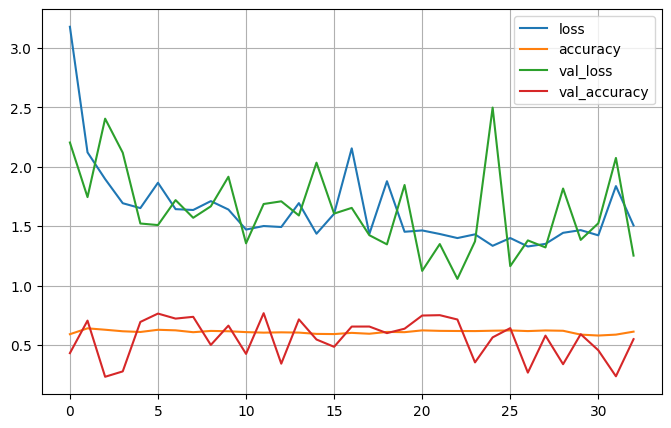

In [52]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [58]:
## Evaluating performance on test data

# Generate predictions
predictions_3L = model.predict(
    [test_author_padded, test_byline_padded, test_narrative_padded, test_topic_title_padded, test_body_padded, test_description_padded, test_title_padded]
)


#Apply a threshold to convert probabilities to binary classification output if needed
predicted_3L = (predictions_3L > 0.5).astype(int)

153/153 [==============================] - 3s 20ms/step


### 4.2.5 - Experimenting with Varying Neurons in Hidden Layer

In [22]:
K.clear_session()
embedding_dim = 100  # For GloVe embeddings with 100 dimensions
vocab_size = len(body_tokenizer.word_index) + 1
max_length=max_length_used

# Initialize an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe vectors
for word, i in body_tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # words not found in embedding index will be all-zeros

        #Next modularize model architecture for flexible reproducability and further neuron variation experimentation

def build_functional_model(num_neurons):
    K.clear_session()

    # Define input layers
    inputs = [
        Input(shape=(max_length,), dtype='int32') for _ in range(7)
    ]

    # Shared embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )

    # Embedding layers for each input
    embeddings = [embedding_layer(input) for input in inputs]

    # Concatenate embeddings
    concatenated = concatenate(embeddings)
    concatenated = Flatten()(concatenated)

    # Dense hidden layer with variable neurons
    hidden = Dense(num_neurons, activation="relu", kernel_regularizer=l2(0.01))(concatenated)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(0.5)(hidden)

    # Output layer
    output = Dense(1, activation='sigmoid')(hidden)

    # Build and compile model
    new_model = Model(inputs=inputs, outputs=output)
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return new_model

In [25]:
#Create early stopping callback,monitoring val_loss in the training process
earlyStopping_3L_min = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

neuron_models = []

neuron_counts = [8,16,24,32,40] #Chose lower neuron numbers to avoid exhausting memory during experimentation
histories = [] #creating a list to store all trained models for each neuron count

train_data=[train_author_padded, train_byline_padded, train_narrative_padded, train_topic_title_padded, train_body_padded, train_description_padded, train_title_padded]
val_data=[val_author_padded, val_byline_padded, val_narrative_padded, val_topic_title_padded, val_body_padded, val_description_padded, val_title_padded]

set_seed(42)  # For reproduceability and consistency

for neurons in neuron_counts: #iteratively training models with varying number of neurons in the hidden layer
    test_model = build_functional_model(neurons)
    history = test_model.fit(train_data, y_train_NN_base, validation_data=(val_data, y_val_NN_base), epochs=100, batch_size=32,class_weight=class_weights_dict,
                             callbacks=[earlyStopping_3L_min], verbose=2)
    neuron_models.append(test_model)
    histories.append(history) #appending trained model from each iteration into histories list
    print(f"End of test for {neurons} Neurons in hidden layer\n\n") #cosmetic addition for possible debugging:)

Epoch 1/100
494/494 - 20s - loss: 1.2041 - accuracy: 0.5425 - val_loss: 0.9334 - val_accuracy: 0.5665 - 20s/epoch - 41ms/step
Epoch 2/100
494/494 - 16s - loss: 0.9810 - accuracy: 0.6076 - val_loss: 0.9053 - val_accuracy: 0.6678 - 16s/epoch - 32ms/step
Epoch 3/100
494/494 - 16s - loss: 1.0065 - accuracy: 0.6570 - val_loss: 1.0945 - val_accuracy: 0.5519 - 16s/epoch - 32ms/step
Epoch 4/100
494/494 - 16s - loss: 1.0282 - accuracy: 0.6608 - val_loss: 0.9556 - val_accuracy: 0.7584 - 16s/epoch - 32ms/step
Epoch 5/100
Restoring model weights from the end of the best epoch: 2.
494/494 - 16s - loss: 0.9963 - accuracy: 0.6305 - val_loss: 1.0065 - val_accuracy: 0.5493 - 16s/epoch - 32ms/step
Epoch 5: early stopping
End of test for 8 Neurons in hidden layer


Epoch 1/100
494/494 - 24s - loss: 1.5584 - accuracy: 0.5614 - val_loss: 0.9015 - val_accuracy: 0.8284 - 24s/epoch - 48ms/step
Epoch 2/100
494/494 - 21s - loss: 1.1317 - accuracy: 0.6517 - val_loss: 1.0080 - val_accuracy: 0.7323 - 21s/epoch - 4

### 4.2.6 - Plotting neuron count experiment results

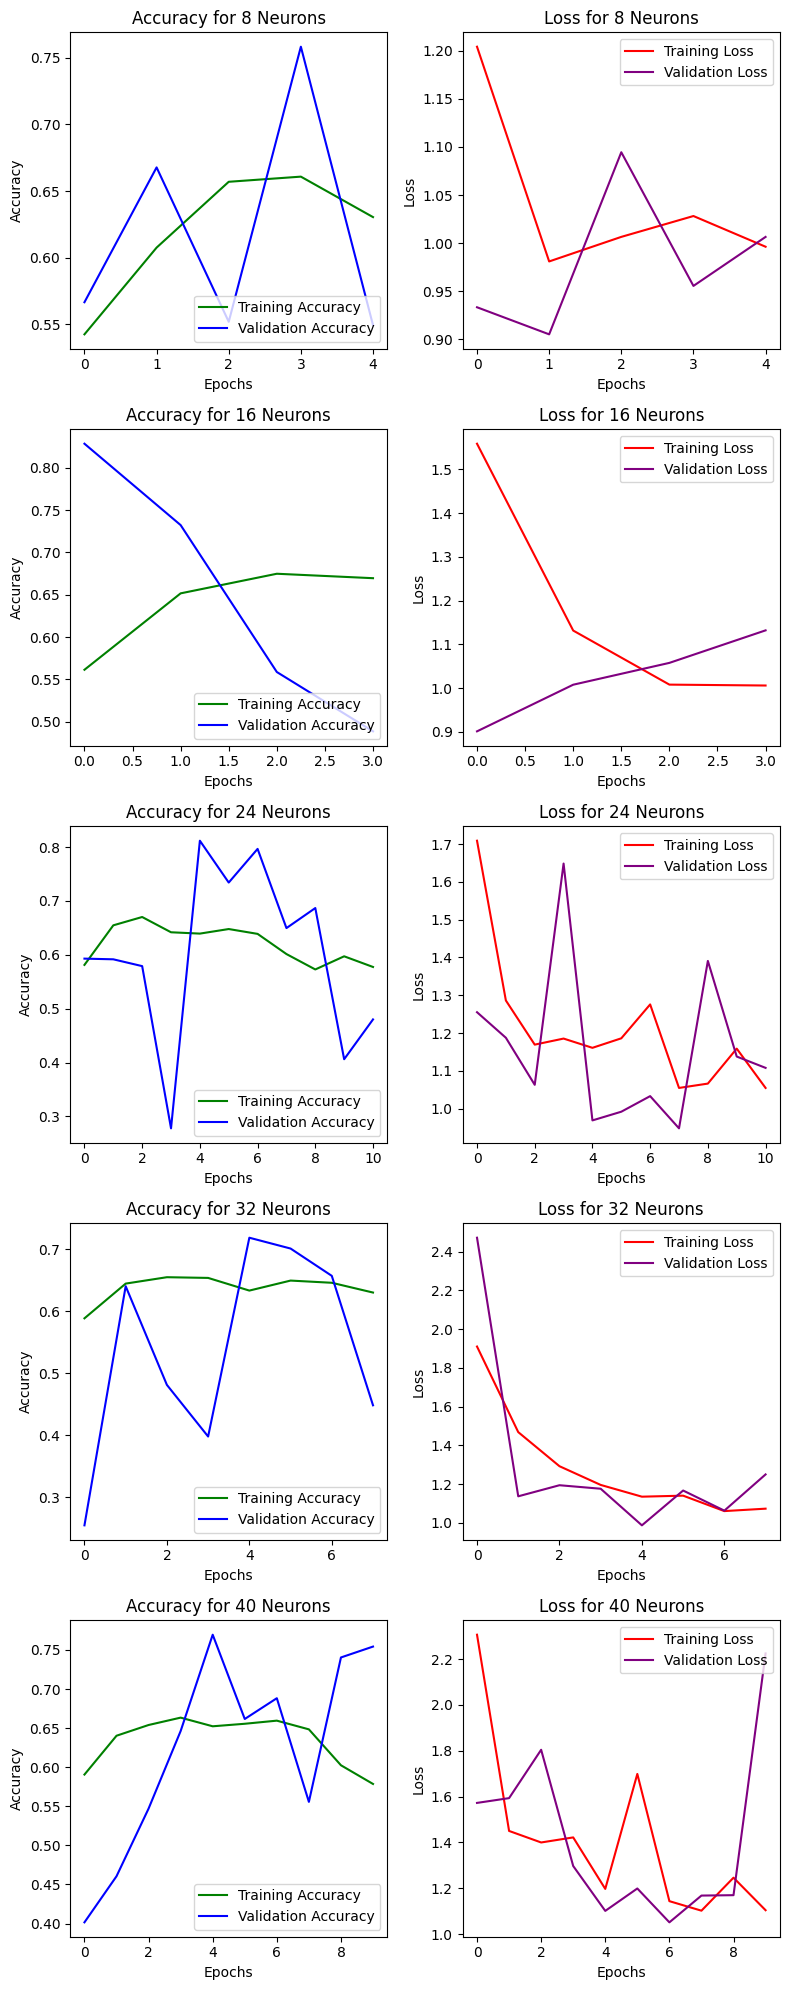

In [26]:
import matplotlib.pyplot as plt

# Number of neuron configurations
num_configs = len(neuron_counts)
cols = 2  # Number of columns in the subplot grid (one for accuracy, one for loss)
rows = num_configs  # One row per neuron configuration

plt.figure(figsize=(8, 4 * rows))  # Adjust the figure size based on the number of rows

# Loop through each neuron configuration
for i in range(num_configs):
    # Plot Training and Validation Accuracy
    plt.subplot(rows, cols, 2 * i + 1)  # Locate subplot for accuracy
    plt.plot(histories[i].history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(histories[i].history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.title(f'Accuracy for {neuron_counts[i]} Neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot Training and Validation Loss
    plt.subplot(rows, cols, 2 * i + 2)  # Locate subplot for loss
    plt.plot(histories[i].history['loss'], label='Training Loss', color='red')
    plt.plot(histories[i].history['val_loss'], label='Validation Loss', color='purple')
    plt.title(f'Loss for {neuron_counts[i]} Neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## 4.3 - Deep neural network model building

### 4.3.1 - Model building and training

In [19]:
K.clear_session()
embedding_dim = 100  # For GloVe embeddings with 100 dimensions
vocab_size = len(body_tokenizer.word_index) + 1
max_length=max_length_used

# Initialize an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with GloVe vectors
for word, i in body_tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # words not found in embedding index will be all-zeros

        #Next modularize model architecture for flexible reproducability and further neuron variation experimentation

In [23]:
#Create early stopping callback,monitoring val_loss in the training process
earlyStopping_DNN = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Define deep learning model
def build_deep_model(num_layers, neurons_per_layer, activation_function):
    K.clear_session()

    # Define input layers
    inputs = [
        Input(shape=(max_length,), dtype='int32') for _ in range(7)
    ]

    # Shared embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )

    # Embedding layers for each input
    embeddings = [embedding_layer(input) for input in inputs]

    # Concatenate embeddings
    concatenated = concatenate(embeddings)
    concatenated = Flatten()(concatenated)

    # Adding multiple dense layers
    x = concatenated
    for _ in range(num_layers):
        x = Dense(neurons_per_layer, activation=activation_function, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Build and compile model
    new_model = Model(inputs=inputs, outputs=output)
    new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return new_model

set_seed(42)  # For reproduceability and consistency

layer_configs = [2, 3, 4]
neurons_per_layer = 32  # Constant number of neurons for comparison
activation_function = 'relu'  # Constant activation function for this experiment

train_data=[train_author_padded, train_byline_padded, train_narrative_padded, train_topic_title_padded, train_body_padded, train_description_padded, train_title_padded]
val_data=[val_author_padded, val_byline_padded, val_narrative_padded, val_topic_title_padded, val_body_padded, val_description_padded, val_title_padded]

layer_histories = []
for config in layer_configs:
    model = build_deep_model(config, neurons_per_layer, activation_function)
    history = model.fit(train_data, y_train_NN_base, validation_data=(val_data, y_val_NN_base), epochs=50, batch_size=32, callbacks=[earlyStopping_DNN],
    class_weight=class_weights_dict, verbose=2)
    layer_histories.append(history)

Epoch 1/50
494/494 - 37s - loss: 2.7916 - accuracy: 0.5729 - val_loss: 1.9829 - val_accuracy: 0.8011 - 37s/epoch - 74ms/step
Epoch 2/50
494/494 - 31s - loss: 1.8674 - accuracy: 0.6110 - val_loss: 1.6386 - val_accuracy: 0.8019 - 31s/epoch - 64ms/step
Epoch 3/50
494/494 - 31s - loss: 1.4670 - accuracy: 0.6376 - val_loss: 1.0887 - val_accuracy: 0.7897 - 31s/epoch - 63ms/step
Epoch 4/50
494/494 - 31s - loss: 1.3581 - accuracy: 0.6325 - val_loss: 1.1830 - val_accuracy: 0.6123 - 31s/epoch - 62ms/step
Epoch 5/50
494/494 - 31s - loss: 1.2862 - accuracy: 0.6036 - val_loss: 1.1805 - val_accuracy: 0.6159 - 31s/epoch - 62ms/step
Epoch 6/50
494/494 - 31s - loss: 1.1824 - accuracy: 0.6184 - val_loss: 0.9352 - val_accuracy: 0.8019 - 31s/epoch - 63ms/step
Epoch 7/50
494/494 - 31s - loss: 1.1739 - accuracy: 0.6289 - val_loss: 0.9474 - val_accuracy: 0.7955 - 31s/epoch - 62ms/step
Epoch 8/50
494/494 - 31s - loss: 1.2989 - accuracy: 0.6105 - val_loss: 1.2847 - val_accuracy: 0.5276 - 31s/epoch - 62ms/step


### 4.3.2 - Visualized Performance Changes with Varying Layers

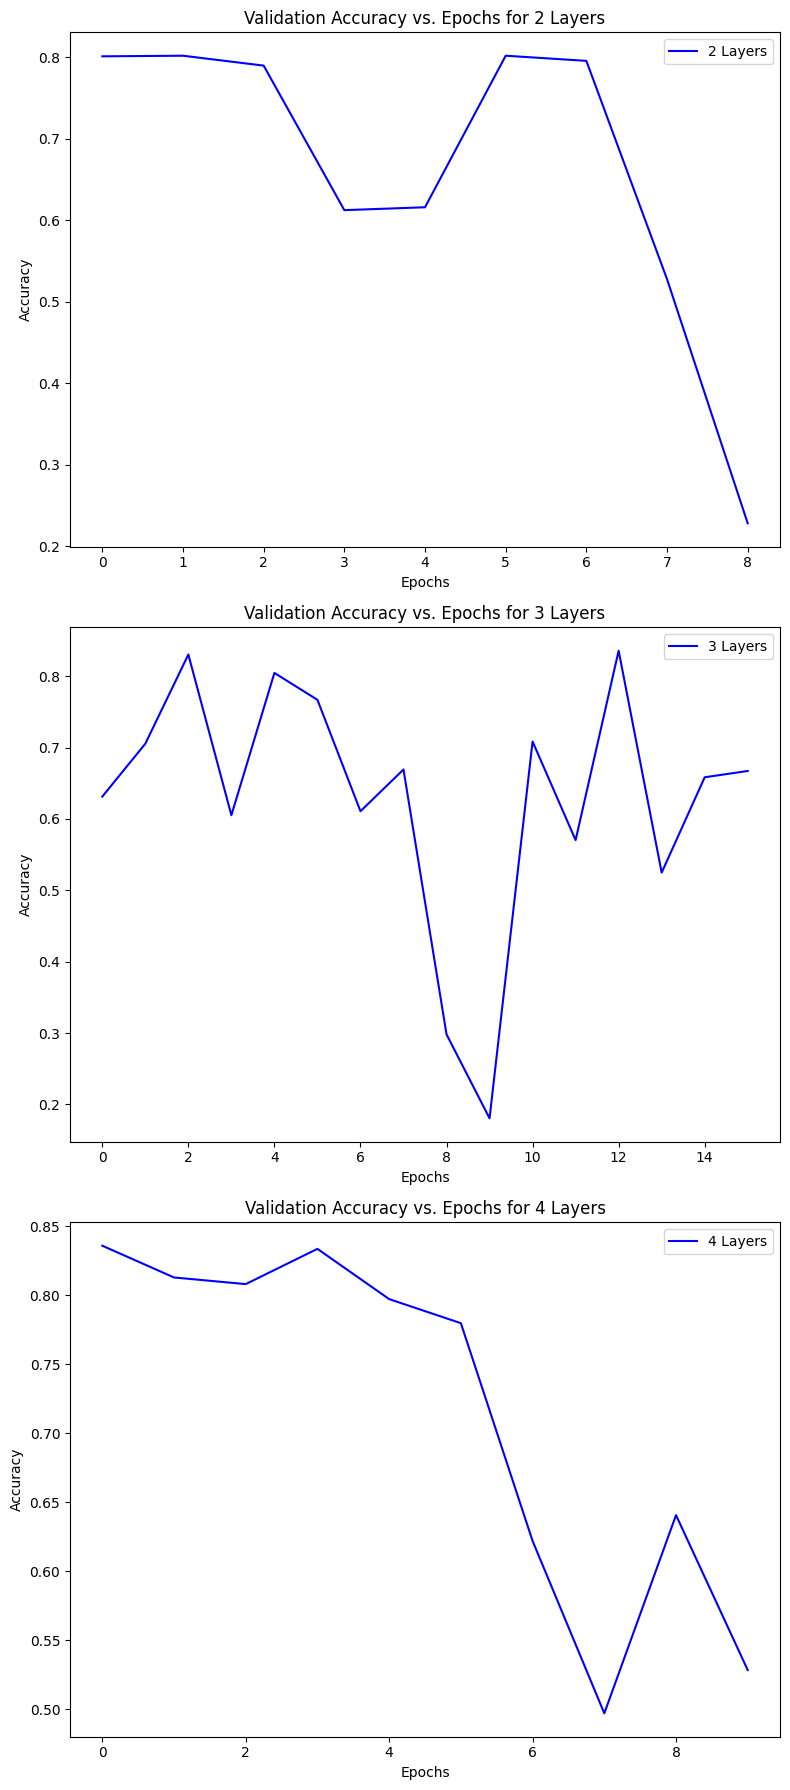

In [27]:
# Determine the number of subplots needed (one for each layer configuration)
num_configs = len(layer_configs)

plt.figure(figsize=(8, 6 * num_configs))  # Adjust the overall figure size

# Loop through each history and create a subplot for each
for i, history in enumerate(layer_histories):
    plt.subplot(num_configs, 1, i + 1)  # Define subplot position (num_configs rows, 1 column per plot)
    plt.plot(history.history['val_accuracy'], label=f'{layer_configs[i]} Layers', color='blue')
    plt.title(f'Validation Accuracy vs. Epochs for {layer_configs[i]} Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.show()

### 4.3.3 - Visualized Performance Changes with Varying Activation Function

In [30]:
activation_functions = ['relu', 'tanh', 'sigmoid']
activation_histories = []
activation_compiled=[]


set_seed(42)
for function in activation_functions:
    model = build_deep_model(3, 32, function)  # Using 3 layers as a standard depth for comparison
    history = model.fit(train_data, y_train_NN_base, validation_data=(val_data, y_val_NN_base), epochs=100, batch_size=32, class_weight=class_weights_dict, callbacks=[earlyStopping_DNN], verbose=2)
    activation_compiled.append(history)
    activation_histories.append(history.history['val_accuracy'][-1])

Epoch 1/100
494/494 - 36s - loss: 3.2572 - accuracy: 0.5099 - val_loss: 2.2210 - val_accuracy: 0.7019 - 36s/epoch - 73ms/step
Epoch 2/100
494/494 - 32s - loss: 1.9869 - accuracy: 0.5594 - val_loss: 1.8622 - val_accuracy: 0.6288 - 32s/epoch - 64ms/step
Epoch 3/100
494/494 - 32s - loss: 1.7197 - accuracy: 0.5922 - val_loss: 1.4077 - val_accuracy: 0.8074 - 32s/epoch - 64ms/step
Epoch 4/100
494/494 - 32s - loss: 1.5150 - accuracy: 0.5942 - val_loss: 1.2823 - val_accuracy: 0.6776 - 32s/epoch - 64ms/step
Epoch 5/100
494/494 - 32s - loss: 1.2794 - accuracy: 0.6170 - val_loss: 1.1884 - val_accuracy: 0.6617 - 32s/epoch - 64ms/step
Epoch 6/100
494/494 - 31s - loss: 1.2563 - accuracy: 0.6284 - val_loss: 1.4745 - val_accuracy: 0.4428 - 31s/epoch - 63ms/step
Epoch 7/100
494/494 - 32s - loss: 1.2432 - accuracy: 0.6187 - val_loss: 1.0366 - val_accuracy: 0.6622 - 32s/epoch - 64ms/step
Epoch 8/100
494/494 - 31s - loss: 1.3369 - accuracy: 0.6024 - val_loss: 1.1845 - val_accuracy: 0.6425 - 31s/epoch - 63

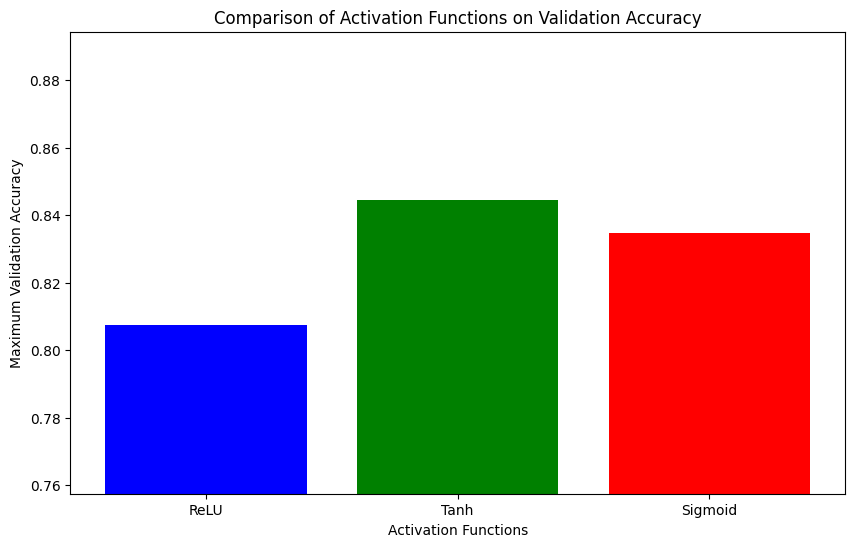

In [33]:
# Prepare data for plotting
activation_functions = ['ReLU', 'Tanh', 'Sigmoid']  # Human-readable names for the plot
max_val_accuracies = [max(hist.history['val_accuracy']) for hist in activation_compiled]  # Extract max validation accuracy from each history

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(activation_functions, max_val_accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Activation Functions')
plt.ylabel('Maximum Validation Accuracy')
plt.title('Comparison of Activation Functions on Validation Accuracy')
plt.ylim([min(max_val_accuracies) - 0.05, max(max_val_accuracies) + 0.05])  # Adjust limits for better visualization
plt.show()

## 4.4 -  BERT-based siamese network model building

The complex model chosen was a BERT-based Siamese network (BSSN) variant. This model is an adaptation of the Siamese network architecture, which uses two pre-trained BERT models to process the main text feature and the query-based features such as topic title. This allows for deeper relationships to be explored between two sets of tokens from the main text and descriptive features, where dense layers are added for potentially finding more nuanced relationships. Three experiments were conducted to optimise the BSSN model. Neuron counts and dense layers were altered to 32, 64, 128 and 1,2,3 and 4 respectively. Three different activation functions were investigated in the dense layers, which are tanh, sigmoid and relu. Each model contained L2 regularisation (lambda = 0.01) and dropout (0.5) to prevent overfitting and contained a reasonable learning rate (5e-5) to maintain stability.

### 4.4.1 - BSSN model definition

In [ ]:
# Define BERT-based siamese network (BSSN) class as subclass of tf.keras.model
class BSSN(tf.keras.Model):
    def __init__(self, n_neurons, n_layers, activation='relu', n_classes=1, l2_lambda=0.01, drop_rate=0.5):
        super(BSSN, self).__init__()
        # Create two BERT models for two inputs
        self.B_model_body = TFBertModel.from_pretrained('bert-base-uncased')
        self.B_model_combined = TFBertModel.from_pretrained('bert-base-uncased')

        # Freeze the BERT layers
        self.B_model_body.trainable = False
        self.B_model_combined.trainable = False

        # Create custom layers in main text feature
        self.custom_layers_body = []
        for _ in range(n_layers):
            # Includes L2 regularisation with value of lambda
            self.custom_layers_body.append(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
            # Define a drop out rate to mitigate overfitting
            self.custom_layers_body.append(Dropout(drop_rate))

        # Create custom layers in additional text features
        self.custom_layers_combined = []
        for _ in range(n_layers):
            self.custom_layers_combined.append(Dense(n_neurons, activation=activation, kernel_regularizer=l2(l2_lambda)))
            self.custom_layers_combined.append(Dropout(drop_rate))

        # Create classification layer for binary classification
        self.classifier = Dense(n_classes, activation='sigmoid')
    # Define function for forward phase
    def call(self, input_text):
        # Insert tokenised inputs and attention masks
        input_ids_body, attention_mask_body = input_text['input_ids_body'], input_text['attention_mask_body']
        input_ids_combined, attention_mask_combined = input_text['input_ids_combined'], input_text['attention_mask_combined']


        # First main text is processed by BERT model
        outputs_body = self.B_model_body(input_ids_body, attention_mask=attention_mask_body)[1]

        # Additional text is processed by BERT model
        outputs_combined = self.B_model_combined(input_ids_combined, attention_mask=attention_mask_combined)[1]

        # Insert outputs into custom layers
        for layer in self.custom_layers_body:
            outputs_body = layer(outputs_body)
        for layer in self.custom_layers_combined:
            outputs_combined = layer(outputs_combined)

        # Now combine outputs from all text data
        c_output = Concatenate(axis=-1)([outputs_body, outputs_combined])



        # Return classification result
        return self.classifier(c_output)

### 4.4.2 - Training and validating model

### 4.4.2 (A) - Experiment 1 of varying neuron number in custom layer

In [ ]:
# Obtain class weight to address class imbalance
classes_l = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes_l, y=y_train)
class_weights = dict(zip(classes_l, weights))

# Define ealry stopping mechanism on validation loss with 1 epoch patience
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [ ]:
# Create BSSN model with 32 neurons and 1 layer
model_BSSN_32 = BSSN(n_neurons=32, n_layers=1, activation='relu')
# Create BSSN model with 64 neurons and 1 layer
model_BSSN_64 = BSSN(n_neurons=64, n_layers=1, activation='relu')
# Create BSSN model with 128 neurons and 1 layer
model_BSSN_128 = BSSN(n_neurons=128, n_layers=1, activation='relu')

# Compile all models with varying neurons
model_BSSN_32.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_64.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_128.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Fit BSSN model with 32 neurons
history_BSSN_32 = model_BSSN_32.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/3
927/927 [==============================] - 1601s 2s/step - loss: 1.5991 - accuracy: 0.5092 - precision: 0.1669 - recall: 0.5336 - val_loss: 1.3470 - val_accuracy: 0.5314 - val_precision: 0.1864 - val_recall: 0.5839
Epoch 2/3
927/927 [==============================] - 1531s 2s/step - loss: 1.2282 - accuracy: 0.5325 - precision: 0.1882 - recall: 0.5977 - val_loss: 1.1350 - val_accuracy: 0.5676 - val_precision: 0.2058 - val_recall: 0.6069
Epoch 3/3
927/927 [==============================] - 1532s 2s/step - loss: 1.0801 - accuracy: 0.5570 - precision: 0.1963 - recall: 0.5899 - val_loss: 1.0255 - val_accuracy: 0.5937 - val_precision: 0.2170 - val_recall: 0.6018


In [ ]:
# Fit BSSN model with 64 neurons
history_BSSN_64 = model_BSSN_64.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/3
927/927 [==============================] - 1663s 2s/step - loss: 2.4531 - accuracy: 0.5108 - precision_1: 0.1666 - recall_1: 0.5293 - val_loss: 1.9836 - val_accuracy: 0.6036 - val_precision_1: 0.2128 - val_recall_1: 0.5583
Epoch 2/3
927/927 [==============================] - 1590s 2s/step - loss: 1.7382 - accuracy: 0.5571 - precision_1: 0.1922 - recall_1: 0.5693 - val_loss: 1.5375 - val_accuracy: 0.5850 - val_precision_1: 0.2191 - val_recall_1: 0.6338
Epoch 3/3
927/927 [==============================] - 1588s 2s/step - loss: 1.4075 - accuracy: 0.5594 - precision_1: 0.1958 - recall_1: 0.5822 - val_loss: 1.2923 - val_accuracy: 0.6097 - val_precision_1: 0.2336 - val_recall_1: 0.6440


In [ ]:
# Fit BSSN model with 128 neurons
history_BSSN_128 = model_BSSN_128.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1 )

Epoch 1/3
927/927 [==============================] - 1658s 2s/step - loss: 3.7227 - accuracy: 0.5301 - precision_2: 0.1721 - recall_2: 0.5237 - val_loss: 2.7384 - val_accuracy: 0.6356 - val_precision_2: 0.2314 - val_recall_2: 0.5621
Epoch 2/3
927/927 [==============================] - 1579s 2s/step - loss: 2.2819 - accuracy: 0.5510 - precision_2: 0.1895 - recall_2: 0.5684 - val_loss: 1.8850 - val_accuracy: 0.7417 - val_precision_2: 0.2879 - val_recall_2: 0.4302
Epoch 3/3
927/927 [==============================] - 1578s 2s/step - loss: 1.7006 - accuracy: 0.5828 - precision_2: 0.2090 - recall_2: 0.5964 - val_loss: 1.4871 - val_accuracy: 0.7247 - val_precision_2: 0.2812 - val_recall_2: 0.4763


### 4.4.2 (B) - Experiment 2 of varying dense layers in neural network

In [ ]:
# Create BSSN model with 128 neurons and 2 layers
model_BSSN_2Layer = BSSN(n_neurons=128, n_layers=2, activation='relu')
# Create BSSN model with 128 neurons and 3 layers
model_BSSN_3Layer = BSSN(n_neurons=128, n_layers=3, activation='relu')
# Create BSSN model with 128 neurons and 4 layers
model_BSSN_4Layer = BSSN(n_neurons=128, n_layers=4, activation='relu')
# Create BSSN model with 128 neurons and 5 layers
model_BSSN_5Layer = BSSN(n_neurons=128, n_layers=5, activation='relu')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Compile all models with varying layers
model_BSSN_2Layer.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_3Layer.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_4Layer.compile(optimizer=Adam(learning_rate=5e-3), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_5Layer.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
# Fit BSSN model with 128 neurons and 2 layers
history_BSSN_2Layer = model_BSSN_2Layer.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights,verbose=1)

Epoch 1/3
927/927 [==============================] - 1582s 2s/step - loss: 3.5881 - accuracy: 0.5157 - precision_3: 0.1684 - recall_3: 0.5301 - val_loss: 2.9146 - val_accuracy: 0.5447 - val_precision_3: 0.1959 - val_recall_3: 0.6056
Epoch 2/3
927/927 [==============================] - 1581s 2s/step - loss: 2.4713 - accuracy: 0.5281 - precision_3: 0.1721 - recall_3: 0.5271 - val_loss: 2.1086 - val_accuracy: 0.3684 - val_precision_3: 0.1788 - val_recall_3: 0.8335
Epoch 3/3
927/927 [==============================] - 1577s 2s/step - loss: 1.8147 - accuracy: 0.5511 - precision_3: 0.1862 - recall_3: 0.5525 - val_loss: 1.5993 - val_accuracy: 0.4045 - val_precision_3: 0.1799 - val_recall_3: 0.7772


In [ ]:
# Fit BSSN model with 128 neurons and 3 layers
history_BSSN_3Layer = model_BSSN_3Layer.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights,verbose=1)

Epoch 1/3
927/927 [==============================] - 1641s 2s/step - loss: 7.9669 - accuracy: 0.5259 - precision_4: 0.1571 - recall_4: 0.4634 - val_loss: 6.1663 - val_accuracy: 0.2206 - val_precision_4: 0.1607 - val_recall_4: 0.9309
Epoch 2/3
927/927 [==============================] - 1577s 2s/step - loss: 4.9307 - accuracy: 0.5107 - precision_4: 0.1635 - recall_4: 0.5151 - val_loss: 3.9190 - val_accuracy: 0.2340 - val_precision_4: 0.1640 - val_recall_4: 0.9385
Epoch 3/3
927/927 [==============================] - 1578s 2s/step - loss: 3.1791 - accuracy: 0.5204 - precision_4: 0.1634 - recall_4: 0.4996 - val_loss: 2.5612 - val_accuracy: 0.3443 - val_precision_4: 0.1712 - val_recall_4: 0.8195


In [ ]:
# Fit BSSN model with 128 neurons and 4 layers
history_BSSN_4Layer = model_BSSN_4Layer.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights,verbose=1)

Epoch 1/3
927/927 [==============================] - 1643s 2s/step - loss: 0.9852 - accuracy: 0.4805 - precision_9: 0.1568 - recall_9: 0.5284 - val_loss: 0.6998 - val_accuracy: 0.1581 - val_precision_9: 0.1581 - val_recall_9: 1.0000
Epoch 2/3
927/927 [==============================] - 1581s 2s/step - loss: 0.6937 - accuracy: 0.4829 - precision_9: 0.1532 - recall_9: 0.5073 - val_loss: 0.6982 - val_accuracy: 0.1581 - val_precision_9: 0.1581 - val_recall_9: 1.0000
Epoch 3/3
927/927 [==============================] - 1581s 2s/step - loss: 0.6935 - accuracy: 0.4932 - precision_9: 0.1526 - recall_9: 0.4901 - val_loss: 0.6956 - val_accuracy: 0.1581 - val_precision_9: 0.1581 - val_recall_9: 1.0000


### 4.4.2 (C) - Experiment 3 of varying the activation function in the dense layers

In [ ]:
# Create BSSN model with 128 neurons, 1 layer and the relu activation function
model_BSSN_relu = BSSN(n_neurons=128, n_layers=1, activation='relu')
# Create BSSN model with 128 neurons, 1 layer and the sigmoid activation function
model_BSSN_sigmoid = BSSN(n_neurons=128, n_layers=1, activation='sigmoid')
# Create BSSN model with 128 neurons, 1 layer and the tanh activation function
model_BSSN_tanh = BSSN(n_neurons=128, n_layers=1, activation='tanh')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Compile all models with varying activation function
model_BSSN_relu.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_sigmoid.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model_BSSN_tanh.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
# Fit BSSN model with 128 neurons, 1 layer and using the relu activation function
history_BSSN_relu = model_BSSN_relu.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/3
927/927 [==============================] - 1652s 2s/step - loss: 3.7632 - accuracy: 0.5328 - precision_3: 0.1766 - recall_3: 0.5404 - val_loss: 2.7781 - val_accuracy: 0.6706 - val_precision_3: 0.2395 - val_recall_3: 0.4981
Epoch 2/3
927/927 [==============================] - 1581s 2s/step - loss: 2.3277 - accuracy: 0.5590 - precision_3: 0.1924 - recall_3: 0.5667 - val_loss: 1.9365 - val_accuracy: 0.6947 - val_precision_3: 0.2575 - val_recall_3: 0.4942
Epoch 3/3
927/927 [==============================] - 1580s 2s/step - loss: 1.7492 - accuracy: 0.5865 - precision_3: 0.2076 - recall_3: 0.5809 - val_loss: 1.5244 - val_accuracy: 0.7615 - val_precision_3: 0.3067 - val_recall_3: 0.4033


In [ ]:
# Fit BSSN model with 128 neurons, 1 layer and using the sigmoid activation function
history_BSSN_sigmoid = model_BSSN_sigmoid.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/3
927/927 [==============================] - 1642s 2s/step - loss: 3.5715 - accuracy: 0.5056 - precision_4: 0.1627 - recall_4: 0.5189 - val_loss: 2.4204 - val_accuracy: 0.6170 - val_precision_4: 0.2069 - val_recall_4: 0.5019
Epoch 2/3
927/927 [==============================] - 1582s 2s/step - loss: 1.9091 - accuracy: 0.5138 - precision_4: 0.1663 - recall_4: 0.5232 - val_loss: 1.4780 - val_accuracy: 0.5868 - val_precision_4: 0.2091 - val_recall_4: 0.5800
Epoch 3/3
927/927 [==============================] - 1581s 2s/step - loss: 1.2860 - accuracy: 0.5243 - precision_4: 0.1705 - recall_4: 0.5258 - val_loss: 1.0887 - val_accuracy: 0.6399 - val_precision_4: 0.2228 - val_recall_4: 0.5134


In [ ]:
# Fit BSSN model with 128 neurons, 1 layer and using the tanh activation function
history_BSSN_tanh = model_BSSN_tanh.fit(train_dataset, epochs=3, validation_data=(val_dataset), callbacks = [early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/3
927/927 [==============================] - 1641s 2s/step - loss: 4.2174 - accuracy: 0.5286 - precision_5: 0.1737 - recall_5: 0.5340 - val_loss: 3.3893 - val_accuracy: 0.8204 - val_precision_5: 0.3648 - val_recall_5: 0.1831
Epoch 2/3
927/927 [==============================] - 1578s 2s/step - loss: 3.0865 - accuracy: 0.5618 - precision_5: 0.1957 - recall_5: 0.5770 - val_loss: 2.6355 - val_accuracy: 0.8142 - val_precision_5: 0.3800 - val_recall_5: 0.2778
Epoch 3/3
927/927 [==============================] - 1578s 2s/step - loss: 2.4978 - accuracy: 0.5882 - precision_5: 0.2127 - recall_5: 0.6015 - val_loss: 2.1558 - val_accuracy: 0.8279 - val_precision_5: 0.4169 - val_recall_5: 0.2215


### 4.4.3 - BSSN model testing

### 4.4.3 (A) - Varying the neuron number in dense layers

In [ ]:
# Evaluate BSSN model with 32 neurons and 1 layer on testing data
test_loss_32, test_accuracy_32 = model_BSSN_32.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 32 neurons and 1 layer: {test_loss_32}")
print(f"Test accuracy for model with 32 neurons and 1 layer: {test_accuracy_32}")

In [ ]:
# Evaluate BSSN model with 64 neurons and 1 layer on testing data
test_loss_64, test_accuracy_64 = model_BSSN_64.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 64 neurons and 1 layer: {test_loss_64}")
print(f"Test accuracy for model with 64 neurons and 1 layer: {test_accuracy_64}")

In [ ]:
# Evaluate BSSN model with 128 neurons and 1 layer on testing data
test_loss_128, test_accuracy_128 = model_BSSN_128.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 1 layer: {test_loss_128}")
print(f"Test accuracy for model with 128 neurons and 1 layer: {test_accuracy_128}")

### 4.4.3 (B) - Varying the number of dense layers in neural network

In [ ]:
# Evaluate BSSN model with 128 neurons and 2 layers on testing data
test_loss_2Layer, test_accuracy_2Layer = model_BSSN_2Layer.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 2 layers: {test_loss_2Layer}")
print(f"Test accuracy for model with 128 neurons and 2 layers: {test_accuracy_2Layer}")

In [ ]:
# Evaluate BSSN model with 128 neurons and 3 layers on testing data
test_loss_3Layer, test_accuracy_3Layer = model_BSSN_3Layer.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 2 layers: {test_loss_3Layer}")
print(f"Test accuracy for model with 128 neurons and 2 layers: {test_accuracy_3Layer}")

In [ ]:
# Evaluate BSSN model with 128 neurons and 4 layers on testing data
test_loss_4Layer, test_accuracy_4Layer = model_BSSN_4Layer.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 4 layers: {test_loss_4Layer}")
print(f"Test accuracy for model with 128 neurons and 4 layers: {test_accuracy_4Layer}")

### 4.4.3 (C) - Varying the activation function in the dense layers of the neural network

In [ ]:
# Evaluate BSSN model with 128 neurons, 1 layer and using the relu activation function on testing data
test_loss_relu, test_accuracy_relu = model_BSSN_relu.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 1 layer with the relu activation function: {test_loss_relu}")
print(f"Test accuracy for model with 128 neurons and 1 layer with the relu activation function : {test_accuracy_relu}")

In [ ]:
# Evaluate BSSN model with 128 neurons, 1 layer and using the sigmoid activation function on testing data
test_loss_sigmoid, test_accuracy_sigmoid = model_BSSN_sigmoid.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 1 layer with the sigmoid activation function: {test_loss_sigmoid}")
print(f"Test accuracy for model with 128 neurons and 1 layer with the sigmoid activation function : {test_accuracy_sigmoid}")

In [ ]:
# Evaluate BSSN model with 128 neurons, 1 layer and using the tanh activation function on testing data
test_loss_tanh, test_accuracy_tanh = model_BSSN_tanh.evaluate(test_dataset, verbose=1)
print(f"Test loss for model with 128 neurons and 1 layer with the tanh activation function: {test_loss_tanh}")
print(f"Test accuracy for model with 128 neurons and 1 layer with the tanh activation function : {test_accuracy_tanh}")

### 4.4.4 - Plotting results of BSSN model training and validation accuracy




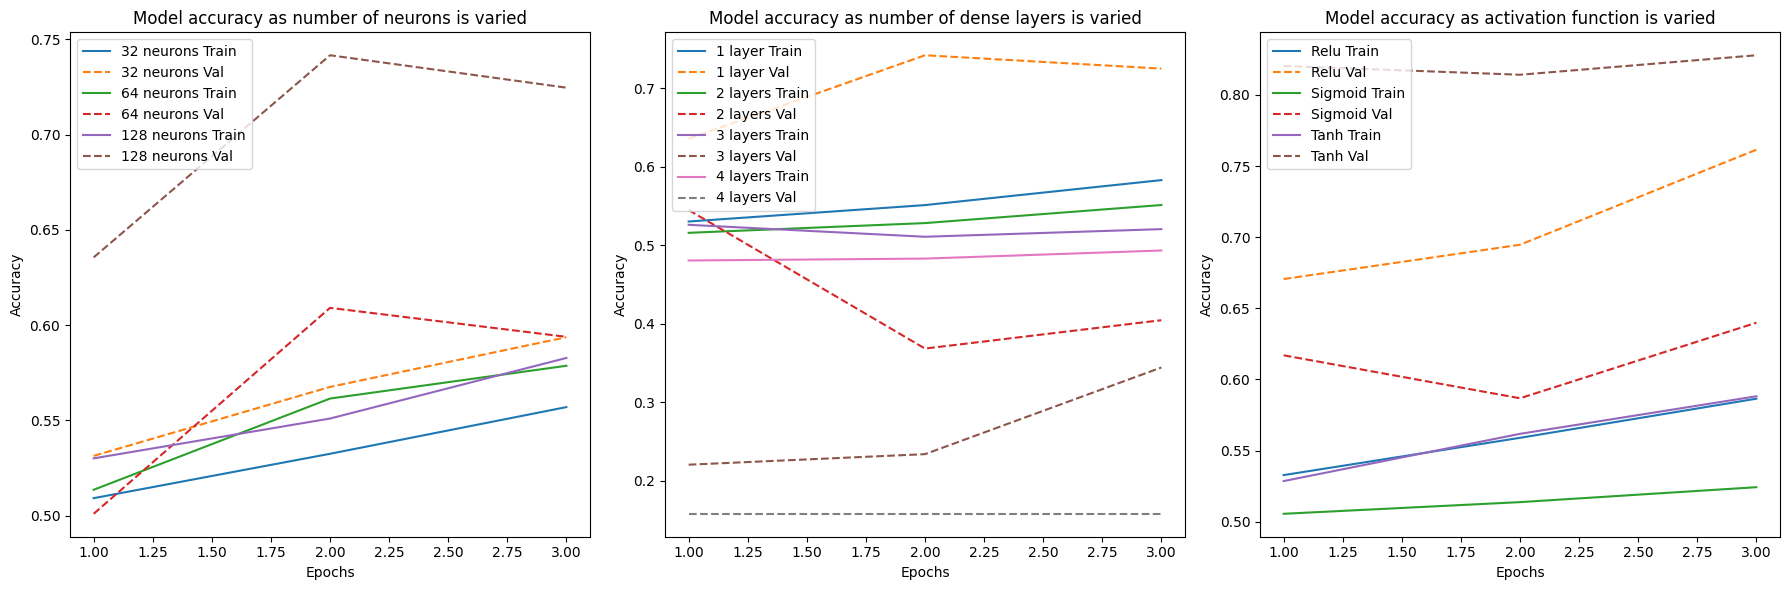

In [ ]:
# Define epochs run in experiments
epochs = [1, 2, 3]

# Manually impute accuracies for traininga nd testing set for each experiment
experiment_1 = {
    '32 neurons': {'train_accuracy': [0.5092, 0.5325, 0.5570], 'val_accuracy': [0.5314, 0.5676, 0.5937]},
    '64 neurons': {'train_accuracy': [0.5136, 0.5615, 0.5787], 'val_accuracy': [0.5010, 0.6091, 0.5939]},
    '128 neurons': {'train_accuracy': [0.5301, 0.5510, 0.5828], 'val_accuracy': [0.6356, 0.7417, 0.7247]}
}

experiment_2 = {
    '1 layer': {'train_accuracy': [0.5301, 0.5510, 0.5828], 'val_accuracy': [0.6356, 0.7417, 0.7247]},
    '2 layers': {'train_accuracy': [0.5157, 0.5281, 0.5511], 'val_accuracy': [0.5447, 0.3684, 0.4045]},
    '3 layers': {'train_accuracy': [0.5259, 0.5107, 0.5204], 'val_accuracy': [0.2206, 0.2340, 0.3443]},
    '4 layers': {'train_accuracy': [0.4805, 0.4829, 0.4932], 'val_accuracy': [0.1581, 0.1581, 0.1581]}
}

experiment_3 = {
    'Relu': {'train_accuracy': [0.5328, 0.5590, 0.5865], 'val_accuracy': [0.6706, 0.6947, 0.7615]},
    'Sigmoid': {'train_accuracy': [0.5056, 0.5138, 0.5243], 'val_accuracy': [0.6170, 0.5868, 0.6399]},
    'Tanh': {'train_accuracy': [0.5286, 0.5618, 0.5882], 'val_accuracy': [0.8204, 0.8142, 0.8279]}
}

# Define subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create for loop to plot experiment 1
for neuron, results in experiment_1.items():
    axes[0].plot(epochs, results['train_accuracy'], label=f'{neuron} Train')
    axes[0].plot(epochs, results['val_accuracy'], label=f'{neuron} Val', linestyle='--')
axes[0].set_title('Model accuracy as number of neurons is varied')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Create for loop to plot experiment 2
for layers, results in experiment_2.items():
    axes[1].plot(epochs, results['train_accuracy'], label=f'{layers} Train')
    axes[1].plot(epochs, results['val_accuracy'], label=f'{layers} Val', linestyle='--')
axes[1].set_title('Model accuracy as number of dense layers is varied')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Create for loop to plot experiment 3
for activation, results in experiment_3.items():
    axes[2].plot(epochs, results['train_accuracy'], label=f'{activation} Train')
    axes[2].plot(epochs, results['val_accuracy'], label=f'{activation} Val', linestyle='--')
axes[2].set_title('Model accuracy as activation function is varied')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

plt.tight_layout()
plt.show()

## 5. Make predictions for Kaggle submission

### 5.1 - 3 layer neural network

In [27]:
predictions_3L = neuron_models[-1].predict([test_author_padded, test_byline_padded, test_narrative_padded, test_topic_title_padded, test_body_padded, test_description_padded, test_title_padded])

153/153 [==============================] - 3s 17ms/step


In [33]:
import zipfile
from google.colab import files

# Convert probability prediction scores to binary output based on threshold
binary_predictions_3L = (predictions_3L >= 0.5).astype(int)




# Convert predictions and document IDs to a dataframe for submission
submission_df_40N = pd.DataFrame({
    'id': test_doc_ids,
    'prediction': binary_predictions_3L.flatten()
})


# Convert dataframe to csv file
submission_df_40N.to_csv('submission_final_40N.csv', index=False)

# Create a zip folder holding submission file
with zipfile.ZipFile('submission_final_40N.zip', 'w') as zipf:
    zipf.write('submission_final_40N.csv', compress_type=zipfile.ZIP_DEFLATED)

# Download submission file
files.download('submission_final_40N.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5.3 - BSSN model

In [ ]:
# Evaluate best model on testing set
model_BSSN_128.evaluate(test_dataset)

In [ ]:
# Make predictions with best model
prediction_128 = model_BSSN_128.predict(test_dataset)

306/306 [==============================] - 406s 1s/step


In [ ]:
import zipfile
from google.colab import files

# Convert probability prediction scores to binary output based on threshold
binary_predictions = (prediction_128 >= 0.5).astype(int)




# Convert predictions and document IDs to a dataframe for submission
submission_df = pd.DataFrame({
    'id': test_doc_ids,
    'prediction': binary_predictions.flatten()
})


# Convert dataframe to csv file
submission_df.to_csv('submission_final.csv', index=False)

# Create a zip folder holding submission file
with zipfile.ZipFile('submission_final.zip', 'w') as zipf:
    zipf.write('submission_final.csv', compress_type=zipfile.ZIP_DEFLATED)

# Download submission file
files.download('submission_final.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6. Results

## 6.1 - Result tables

### 6.1.1 - Standard machine learning model

In [ ]:
# Performance data
performance_data_ML = {
    'Model configuration': ['Logistic regression', 'SVM', 'Decision tree'],


    'Validation accuracy': [[0.82669197, 0.83612781, 0.83106612, 0.83201519, 0.81872825],
                            [0.83934219, 0.84625119, 0.84498576, 0.83992407, 0.83644416],
                            [0.81593928, 0.80544132, 0.81999367, 0.82252452, 0.80227776]]



}

# Define data frame to hold inputed data
p_df_ML = pd.DataFrame(performance_data_ML)

# Calculate mean and std for each model
p_df_ML['Validation mean'] = p_df_ML['Validation accuracy'].apply(np.mean)
p_df_ML['Validation std'] = p_df_ML['Validation accuracy'].apply(np.std)

# Print dataframe showing performance
print(p_df_ML[['Model configuration', 'Validation mean', 'Validation std']])

   Model configuration  Validation mean  Validation std
0  Logistic regression         0.828926        0.005916
1                  SVM         0.841389        0.003671
2        Decision tree         0.813235        0.008001


### 6.1.2 - 3 layer neural network

In [6]:
# Performance data
performance_data_3L = {
    'Model configuration for 3 layer network': ['100 neuron', '8 neuron', '16 neuron', '24 neuron', '32 neuron', '40 neuron'],

    'Training accuracy': [[0.5922, 0.6415, 0.6298, 0.6169, 0.6108, 0.6293, 0.6247, 0.6090, 0.6198, 0.6170, 0.6098, 0.6053, 0.6079, 0.6057, 0.5948, 0.5933, 0.6034, 0.5960, 0.6114, 0.6093, 0.6243, 0.6203, 0.6191, 0.6184, 0.6215, 0.6239, 0.6184, 0.6236,0.6210],
                          [0.5425, 0.6076, 0.6570, 0.6608, 0.6395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0.5614, 0.6517, 0.6748, 0.6696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0.5812, 0.6547, 0.6701, 0.6418, 0.6393, 0.6478, 0.6388, 0.6014, 0.5728, 0.5972, 0.5774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0.5889, 0.6449, 0.6552, 0.6541, 0.6336, 0.6498, 0.6462, 0.6305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0.5906, 0.6403, 0.6540, 0.6634, 0.6523, 0.6556, 0.6596, 0.6484, 0.6025, 0.5786,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],



    'Validation accuracy': [[0.4329, 0.7065, 0.2341, 0.2794, 0.6953, 0.7657, 0.7234, 0.7384, 0.5018, 0.6645, 0.4266, 0.7690, 0.3444, 0.7169, 0.5476, 0.4861, 0.6564, 0.6566, 0.6012, 0.6384, 0.7492, 0.7523, 0.7158, 0.3550, 0.5655, 0.6432, 0.2690, 0.5802, 0.3398],
                            [0.5665, 0.6678, 0.5519, 0.7584, 0.5493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0.8284, 0.7323, 0.5587, 0.4886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0.5929, 0.5916, 0.5789, 0.2778, 0.8117, 0.7341, 0.7966, 0.6495, 0.6867, 0.4061, 0.4800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0.2551, 0.6407, 0.4815, 0.3983, 0.7189, 0.7014, 0.6574, 0.4486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                            [0.4016, 0.4605, 0.5471, 0.6463, 0.7695, 0.6617, 0.6883, 0.5557, 0.7404, 0.7543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]




}

# Define data frame to hold inputed data
p_df_3L = pd.DataFrame(performance_data_3L)
# Calculate mean and std for each model
p_df_3L['Training mean'] = p_df_3L['Training accuracy'].apply(np.mean)
p_df_3L['Training std'] = p_df_3L['Training accuracy'].apply(np.std)
p_df_3L['Validation mean'] = p_df_3L['Validation accuracy'].apply(np.mean)
p_df_3L['Validation std'] = p_df_3L['Validation accuracy'].apply(np.std)

# Print dataframe showing performance
print(p_df_3L[['Model configuration for 3 layer network', 'Training mean', 'Training std', 'Validation mean', 'Validation std']])

  Model configuration for 3 layer network  Training mean  Training std  \
0                              100 neuron       0.614428      0.011565   
1                                8 neuron       0.119515      0.245683   
2                               16 neuron       0.088190      0.221130   
3                               24 neuron       0.235259      0.301636   
4                               32 neuron       0.175972      0.285307   
5                               40 neuron       0.218803      0.302109   

   Validation mean  Validation std  
0         0.570869        0.165764  
1         0.118996        0.246531  
2         0.089931        0.230355  
3         0.227790        0.306826  
4         0.148341        0.253942  
5         0.214669        0.304204  


### 6.1.3 - Deep neural network model

In [8]:
# Performance data
performance_data_DNN = {
    'Model configuration for deep neural network': ['2 dense layers', '3 dense layers', '4 dense layers', 'Relu', 'Tanh', 'Sigmoid'],

    'Training accuracy': [[0.6376, 0.6325, 0.6036, 0.6184, 0.6289, 0.6105, 0.6116,0,0,0,0,0,0,0,0,0],
                          [0.5228, 0.5733, 0.6363, 0.6714, 0.6379, 0.6342, 0.6193, 0.6284, 0.6239, 0.5989, 0.6105, 0.6065, 0.5975, 0.6221, 0.6235, 0.6397],
                          [0.4994, 0.5380, 0.5740, 0.6298, 0.6782, 0.6811, 0.6414, 0.6287, 0.6289, 0.6070,0,0,0,0,0,0],
                          [0.5942, 0.6170, 0.6284, 0.6187, 0.6024, 0.6151, 0.6279,0,0,0,0,0,0,0,0,0],
                          [0.5001, 0.4986, 0.5140, 0.5120, 0.5098, 0.5539, 0.5352, 0.5274, 0.5458, 0.5149,0,0,0,0,0,0],
                          [0.5044, 0.5084, 0.5412, 0.5593, 0.5603, 0.5967, 0.5713, 0.5747, 0.6022,0,0,0,0,0,0,0]],



    'Validation accuracy': [[0.7897, 0.6123, 0.6159, 0.8019, 0.7955, 0.5276, 0.2280,0,0,0,0,0,0,0,0,0],
                            [0.6313, 0.7055, 0.8305, 0.6053, 0.8047, 0.7670, 0.6108, 0.6693, 0.2981, 0.1804, 0.7085, 0.5703, 0.8358, 0.5248, 0.6584,0.6673],
                            [0.8360, 0.8130, 0.8082, 0.8338, 0.7973, 0.7799, 0.6220, 0.4970, 0.6407, 0.5283,0,0,0,0,0,0],
                            [0.6776, 0.6617, 0.4428, 0.6622, 0.6425, 0.5595, 0.7457,0,0,0,0,0,0,0,0,0],
                            [0.5959, 0.1840, 0.7968, 0.8444, 0.8338, 0.8330, 0.8398, 0.2156, 0.8406, 0.8429,0,0,0,0,0,0],
                            [0.2700, 0.6460, 0.7981, 0.3155, 0.4899, 0.8529, 0.2528, 0.8348, 0.2242,0,0,0,0,0,0,0]]




}

# Define data frame to hold inputed data
p_df_DNN = pd.DataFrame(performance_data_DNN)
# Calculate mean and std for each model
p_df_DNN['Training mean'] = p_df_DNN['Training accuracy'].apply(np.mean)
p_df_DNN['Training std'] = p_df_DNN['Training accuracy'].apply(np.std)
p_df_DNN['Validation mean'] = p_df_DNN['Validation accuracy'].apply(np.mean)
p_df_DNN['Validation std'] = p_df_DNN['Validation accuracy'].apply(np.std)

# Print dataframe showing performance
print(p_df_DNN[['Model configuration for deep neural network', 'Training mean', 'Training std', 'Validation mean', 'Validation std']])

  Model configuration for deep neural network  Training mean  Training std  \
0                              2 dense layers       0.271444      0.307887   
1                              3 dense layers       0.615387      0.032048   
2                              4 dense layers       0.381656      0.298837   
3                                        Relu       0.268981      0.305094   
4                                        Tanh       0.325731      0.252703   
5                                     Sigmoid       0.313656      0.277693   

   Validation mean  Validation std  
0         0.273181        0.334480  
1         0.629250        0.172364  
2         0.447263        0.360121  
3         0.274500        0.317006  
4         0.426675        0.385841  
5         0.292763        0.319557  


### 6.1.4 - Complex model, BERT based Siamese network

In [ ]:
# Performance data
performance_data = {
    'Model configuration': ['32 neuron BSSN', '64 neuron BSSN', '128 neuron BSSN', '1 layer BSSN', '2 layer BSSN', '3 layer BSSN', '4 layer BSSN', 'Relu BSSN', 'Sigmoid BSSN', 'Tanh BSSN'],
    'Training accuracy': [[0.5092, 0.5325, 0.5570],
                          [0.5136, 0.5615, 0.5787],
                          [0.5301, 0.5510, 0.5828],
                          [0.5301, 0.5510, 0.5828],
                          [0.5157, 0.5281, 0.5511],
                          [0.5259, 0.5107, 0.5204],
                          [0.4805, 0.4829, 0.4932],
                          [0.5328, 0.5590, 0.5865],
                          [0.5056, 0.5138, 0.5243],
                          [0.5286, 0.5618, 0.5882]],

    'Validation accuracy': [[0.5314, 0.5676, 0.5937],
                            [0.5010, 0.6091, 0.5939],
                            [0.6356, 0.7417, 0.7247],
                            [0.6356, 0.7417, 0.7247],
                            [0.5447, 0.3684, 0.4045],
                            [0.2206, 0.2340, 0.3443],
                            [0.1581, 0.1581, 0.1581],
                            [0.6706, 0.6947, 0.7615],
                            [0.6170, 0.5868, 0.6399],
                            [0.8204, 0.8142, 0.8279]]


}

# Define data frame to hold inputed data
p_df = pd.DataFrame(performance_data)

# Calculate mean and std for each model
p_df['Training mean'] = p_df['Training accuracy'].apply(np.mean)
p_df['Training std'] = p_df['Training accuracy'].apply(np.std)
p_df['Validation mean'] = p_df['Validation accuracy'].apply(np.mean)
p_df['Validation std'] = p_df['Validation accuracy'].apply(np.std)

# Print dataframe showing performance
print(p_df[['Model configuration', 'Training mean', 'Training std', 'Validation mean', 'Validation std']])

  Model configuration  Training mean  Training std  Validation mean  \
0      32 neuron BSSN       0.532900      0.019516         0.564233   
1      64 neuron BSSN       0.551267      0.027544         0.568000   
2     128 neuron BSSN       0.554633      0.021668         0.700667   
3        1 layer BSSN       0.554633      0.021668         0.700667   
4        2 layer BSSN       0.531633      0.014666         0.439200   
5        3 layer BSSN       0.519000      0.006284         0.266300   
6        4 layer BSSN       0.485533      0.005509         0.158100   
7           Relu BSSN       0.559433      0.021925         0.708933   
8        Sigmoid BSSN       0.514567      0.007653         0.614567   
9           Tanh BSSN       0.559533      0.024384         0.820833   

   Validation std  
0        0.025545  
1        0.047781  
2        0.046530  
3        0.046530  
4        0.076042  
5        0.055425  
6        0.000000  
7        0.038450  
8        0.021746  
9        0.005601 

## 6.2 - Result analysis

## 6.2.1 - Standard machine learning baseline

Evidently, the SVM and logistic regression model performed the strongest, where the SVM model particularly had a good balance between recall and precision. The decision tree model showed the worst performance and maybe would require investigation into further ensemble methods to improve performance.

## 6.2.2 - 3 layer neural network (Determining the 'sweet spot')

As can be seen from the graphs, there were sharp deviations (large gaps) between the training and validation accuracy curves for the model with the 24-neuron hidden layer and the model with the 16-neuron hidden layer and the 8-neuron hidden layer, with some of the model’s validation accuracy tanking as the number of epochs increased.

We also saw similar large deviations in the graph between training loss and validation loss curves. These sharp spikes and discrepancies suggest instability in learning and possible overfitting.

However, there was relatively improved balance and stability for the 40-neuron-hidden-layer model curve and the model. Specifically, by the end of the last epoch, the 40-neuron hidden layer returned the highest scores.This would arguably be the “sweet spot”.

## 6.2.3 - Deep neural network

The model with two layers showed severe overfitting early in training or possibly issues with the model's ability to generalize as it adjusted to the data specifics.

The model with three layers demonstrated the most dynamic performance, while it demonstrated such fluctuation, its eventual settling at 0.7, which is reasonably high, points to its ability to balance depth with complexity adequately, possibly making it the best out of the three in adapting to both the nuances and the broader patterns in the dataset.

The model with four 4 deep layers started with an impressive accuracy of 0.85, this model showed a gradual decline to 0.5 by the end of the training process. This performance could indicate that while the added depth initially helped in capturing complex patterns effectively, it ultimately led to overfitting.
Conclusively, increasing the number of layers in a neural network generally enables more complex data representations, but as observed, it also heightens the risk of overfitting, particularly when not balanced with adequate data or regularization.

The 3-layer model, with its moderate depth, provided the best compromise between complexity and generalization, suggesting that for this particular task and dataset, a mid-level network depth is most effective. Future efforts should focus on enhancing model stability and handling overfitting, perhaps through more sophisticated regularization techniques or adjustments in learning rate over epochs. For this, I used a model with three deep layers, each having 32 neurons.
Our implementation --as seen in the visualization-- revealed that using "tanh" as the activation function for the deep layers returned better results (validation accuracy) than the model using ReLu and sigmoid. While performance using ReLu for hidden layers for hidden layers were not far off from performance achieved using tanh, the model with sigmoid activation function performed really bad with validation accuracy falling as low as 0.2

To eveluate the effect of changing the activation function, I used a model with three deep layers, each having 32 neurons.
Our implementation --as seen in the visualization-- revealed that using "tanh" as the activation function for the deep layers returned better results (validation accuracy) than the model using ReLu and sigmoid. While performance using ReLu for hidden layers for hidden layers were not far off from performance achieved using tanh, the model with sigmoid activation function performed really bad with validation accuracy falling as low as 0.2




## 6.2.4 - Complex model, BERT based Siamese network

From experiment one it is evident that as neuron count in the dense layers increased so did the accuracy, but this is not reflected in the recall or precision metrics, which stagnate. 128 neurons gave the best performance. As the neuron number increases the validation and training metrics remain similar, which indicates the use of L2 regularisation and dropouts have effectively mitigated overfitting. A learning rate of 2e-5 seems to be effective in keeping training stabilised.

From experiment two as you increase the number of dense layers the performance shows minimal increase and generalisability decreases significantly. Around 1 or 2 layers seems optimal, where anymore layers decrease performance. The increased complexity in adding layers evidently overrides the regularisation techniques to reduce generalisability. Also, it is evident that 1 to 2 layers balance bias and variance better but when moving to 3 or 4 layers the variance increases and reduces generalisability.

Experiment 3 indicated that both tanh and relu activation functions across training and validation. The tanh had the highest precisiona nd accuracy but with lower recall rates suggesting it may be less ideal for defining relevance as it missed a lot of actual positives. Relu activation function showed the best balance of metrics but did not go as high as tanh. Sigmoid performed poorly for all metrics and struggled with the dataset.


# 7. Summary

## 7.1 - Main summary

We would say the BERT model performed best. Even while limited computational resources limited the number of epochs training I could execute (and made us unable to execute hyperparameter tuning), the BERT model outperformed the Functional API model with a simple structure 40 neurons in a single hidden layer.

But this is not out of place. BERT uses the transformer architecture, which inherently captures the context of words in a sentence from both directions (bidirectional), something crucial for many NLP tasks and not inherently managed by a basic Functional API approach.

Even with minimal fine-tuning (as indicated by only three epochs of training), BERT can rapidly adjust to the specifics of a new task, leveraging its pre-trained background to achieve better performance metrics (80% accuracy) compared to the Functional API model's 77%, which relies entirely on the training process limited to the specific dataset and task without the benefit of pre-learned language representations.

## 7.2 - What to do next

For the BERT model, the next step would be to leverage greater computational resources for enhanced epoch training. It would also be fantastic to deploy larger pre-trained BERT models. Specifically, models like BigBird or Longformer would be arguably better suited, as they efficiently handle longer sequences up to lengths of 4,096 tokens. Effectively, this makes them suitable for tasks that involve long documents or contexts.

An opportunity to try out hyperparameter tuning for the BERT would have been fantastic as well. By adjusting hyperparameters such as learning rate, batch size, number of epochs, and the number of transformer layers, I could have been able to enhance the model's ability to generalize better to new data, thus improving accuracy and reducing overfitting.